In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from simulation_core import Simulation

86400 24 3600


# Description of general analysis for all pools

MEV analysis was performed by next approach:

1. MEV related transactions were estimated by the algorithm which took transaction "sandwiches" with two transactions where values are identical, meaning that transactions most likely where performed to cause tokens prices changes profitable for attacker;
2. Considering that some of the transactions had relatively small capitalization (which does not exclude their possible MEV origin, due to reserves changes in each pool) there will be two sections: one with reviewing all cases and one higher capitalization transactions;
3. For additional analysis was taken information about used gas and fee conform data from Etherscan;
4. For the future analysis, due to some strange data extractions it is required to create custom subgraph collecing info about actual spent gas (found solution takes gas which sender is ready to pay).

There will be concatenation of the original swaps dataframe with gas-related info

### Setting simulation instances that contain all required info

In [2]:
# classic pools
wbtc_usdc_sim = Simulation(experiment_id = 1, x_name = 'WBTC', y_name = 'USDC', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
weth_usdc_sim = Simulation(experiment_id = 2, x_name = 'WETH', y_name = 'USDC', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_", 
                           x_index='1', y_index='0')
wbtc_dai_sim = Simulation(experiment_id = 3, x_name = 'WBTC', y_name = 'DAI', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
fei_weth_sim = Simulation(experiment_id = 4, x_name = 'FEI', y_name = 'WETH', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
hkmt_usdt_sim = Simulation(experiment_id = 5, x_name = 'HKMT', y_name = 'USDT', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
ixs_weth_sim = Simulation(experiment_id = 6, x_name = 'IXS', y_name = 'WETH', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")

### Getting original swaps dataframes

In [3]:
wbtc_usdc_swaps_df = wbtc_usdc_sim.get_original_swaps_df()
weth_usdc_swaps_df = weth_usdc_sim.get_original_swaps_df()
wbtc_dai_swaps_df = wbtc_dai_sim.get_original_swaps_df()
fei_weth_swaps_df = fei_weth_sim.get_original_swaps_df()
hkmt_usdt_swaps_df = hkmt_usdt_sim.get_original_swaps_df()
ixs_weth_swaps_df = ixs_weth_sim.get_original_swaps_df()

### Setting concatenation between original swaps dataframe and gas-related info

In [4]:
classic_pools_list = [wbtc_usdc_swaps_df, weth_usdc_swaps_df, wbtc_dai_swaps_df,
                          fei_weth_swaps_df, hkmt_usdt_swaps_df, ixs_weth_swaps_df]
classic_pools_swaps_df = pd.concat(classic_pools_list)
with open('classic_pools_mevs', 'rb') as f: mevs_transactions_list = pickle.load(f)

mevs_df = pd.read_pickle('classic_pools_mevs_with_gas_df.pkl')
mevs_df['txd'] = mevs_transactions_list
mevs_df

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee
0,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,11279366,54,"107,326",478.76,0.000000122000000001
1,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,11279366,62,"101,057",478.76,0.000000115500000001
2,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,11792953,75,"66,799","1,721.48",0.0000002431
3,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,11792953,3,"103,505","1,721.48",0.000000301463842552
4,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,11803970,67,"139,130","1,679.14",0.000000140400000001
...,...,...,...,...,...,...
705,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,13969479,1,"87,023","3,150.83",0.000000096534076405
706,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,13969481,2,"88,383","3,150.83",0.000000109600853456
707,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,13969481,4,"78,261","3,150.83",0.000000117286586847
708,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,"88,481","2,569.59",0.000000135879365521


In [5]:
mevs_df['txd'].iloc[0]

'0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7fa4a9dad683e2414d9146'

In [6]:
mevs_df = pd.merge(mevs_df, classic_pools_swaps_df, on='txd', how='left')

In [7]:
mevs_df['block'] = pd.to_numeric(mevs_df['block'])
mevs_df['block_position'] = pd.to_numeric(mevs_df['block_position'])
mevs_df['gas_usage_by_tx'] = pd.to_numeric(mevs_df['gas_usage_by_tx'].str.replace(',', ''))
mevs_df['ether_price'] = pd.to_numeric(mevs_df['ether_price'].str.replace(',', ''))
mevs_df['tx_fee'] = pd.to_numeric(mevs_df['tx_fee'].str.replace('wei', ''))
mevs_df['gas_price'] = pd.to_numeric(mevs_df['gas_price']) / 1000000000000000000
mevs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710 entries, 0 to 709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   txd              710 non-null    object        
 1   block            710 non-null    int64         
 2   block_position   710 non-null    int64         
 3   gas_usage_by_tx  710 non-null    int64         
 4   ether_price      710 non-null    float64       
 5   tx_fee           710 non-null    float64       
 6   token_in         710 non-null    object        
 7   token_out        710 non-null    object        
 8   amount_in        710 non-null    float64       
 9   amount_out       710 non-null    float64       
 10  amount_usd       710 non-null    float64       
 11  timestamp        710 non-null    datetime64[ns]
 12  sender           710 non-null    object        
 13  to               710 non-null    object        
 14  gas_price        438 non-null    float64  

### Correlation between features

Conform heatmap there are small strong connections present in the dataset. Price of ethereum correlates with block number, which is explainable by change of Ethereum price through time. In value, out value and capitalization in USD are correlated, but other features have weak correlations.

<AxesSubplot:>

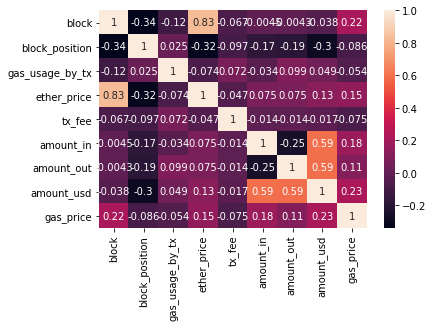

In [8]:
sns.heatmap(mevs_df.corr(), annot=True)

In [9]:
mevs_df.value_counts(subset=['sender']) / 2

sender                                    
0xd78a3280085ee846196cb5fab7d510b279486d44    41.0
0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d    40.0
0x00000000008c4fb1c916e0c88fd4cc402d935e7d    40.0
0x00000000003b3cc22af3ae1eac0440bcee416b40    37.0
0x83f893cc6610bfc695f8e2d4cd0e6d3033dec77e    21.0
0xbfd54d7fb7059d2505069dec2222a81ead7f831a    15.0
0x7a250d5630b4cf539739df2c5dacb4c659f2488d    14.0
0xf164fc0ec4e93095b804a4795bbe1e041497b92a    13.0
0xc1dfd16259c2530e57aea8a2cf106db5671616b0    13.0
0x000000000035b5e5ad9019092c665357240f594e    12.0
0x000000000000294a0d3b43ec78199a84587ae012     8.0
0xa3b0e79935815730d942a444a84d4bd14a339553     8.0
0xe8024625ac740573a379b290175c33eb72a7c6e5     7.0
0x54cd18c5f9d68bee591541700a2042c6fc18e8f5     6.0
0x00000000032962b51589768828ad878876299e14     6.0
0xd59e5b41482ee6283c22e1a6a20756da512ffa97     5.0
0x66f049111958809841bbe4b81c034da2d953aa0c     4.0
0x1ced55180af96c2fab38069aa3e13fa81e024270     4.0
0x9e244643b91ecc1498718cb4f5d22d14a9b12

### Setting scatters of features

There is a problem with dataset of ```tx_fee``` values equal to 1 (possible source error) and therefore records with value around 1 were ignored.

There is almost no connection present between tx fee and gas usage. Can be seen that most of the records are concentrated around small values with some extreme outliers. Therefore it was decided to check connection with gas price.

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


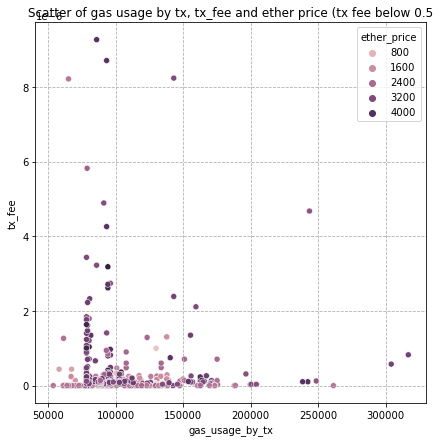

In [10]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['ether_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and ether price (tx fee below 0.5')
plt.show()

In [11]:
mevs_df

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,gas_price,gas_used
0,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,11279366,54,107326,478.76,1.220000e-07,USDC,WBTC,3694.507910,0.209063,3684.217300,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,1.220000e-07,118777
1,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,11279366,62,101057,478.76,1.155000e-07,WBTC,USDC,0.207678,3694.507910,3692.331147,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,1.155000e-07,125946
2,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,11792953,75,66799,1721.48,2.431000e-07,WBTC,USDC,0.814765,30511.102171,30517.868246,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,2.431000e-07,350000
3,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,11792953,3,103505,1721.48,3.014638e-07,USDC,WBTC,30305.000000,0.814765,30311.720370,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,3.014638e-07,230000
4,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,11803970,67,139130,1679.14,1.404000e-07,WBTC,USDC,0.288400,11703.050959,11693.344352,2021-02-06 16:53:21,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,1.404000e-07,290000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,13969479,1,87023,3150.83,9.653408e-08,WETH,IXS,3.258591,64615.874809,10215.913104,2022-01-09 05:32:54,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x499dd900f800fd0a2ed300006000a57f00fa009b,9.653408e-08,200000
706,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,13969481,2,88383,3150.83,1.096009e-07,WETH,IXS,0.204570,4417.639844,641.339915,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,1.096009e-07,550988
707,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,13969481,4,78261,3150.83,1.172866e-07,IXS,WETH,4417.639844,0.223684,701.263874,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,1.172866e-07,128261
708,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,88481,2569.59,1.358794e-07,WETH,IXS,9.850424,153715.045388,27919.796295,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0000000000d41c96294ccdac8612bdfe29c641af,1.358794e-07,108545


Most of the records are placed in the lowest left section, meaning that most of transactions are keeping a small level of gas consumption, but the most interesting moment is that all those low-value cases conform hue are having smallest ```gas_price``` values, meaning that most of the attacks are performed during low gas price. Therefore, low gas price will not cause higher transaction values (there is no strong correlation) but causes bigger MEV activity.

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


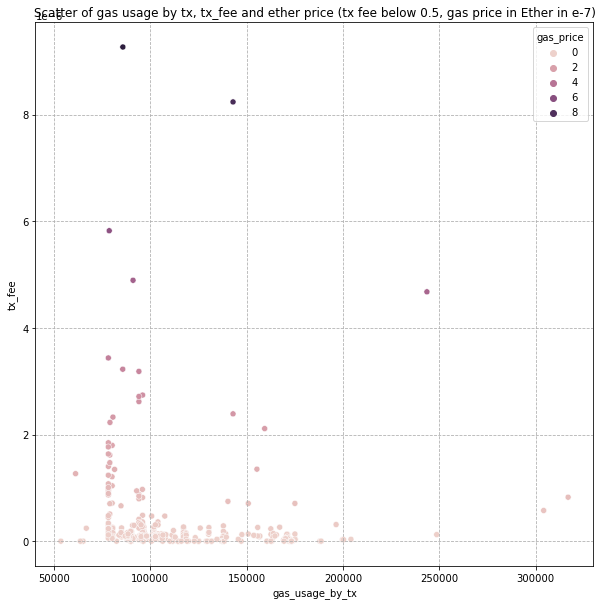

In [12]:
plt.figure(figsize=(10, 10))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['gas_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and ether price (tx fee below 0.5, gas price in Ether in e-7)')
plt.show()

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


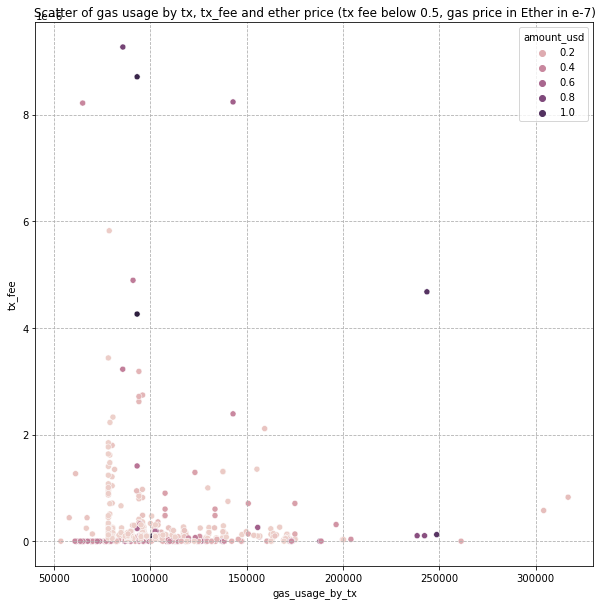

In [13]:
plt.figure(figsize=(10, 10))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 1]['gas_usage_by_tx'],
                mevs_df[mevs_df['tx_fee'] < 1]['tx_fee'],
                hue=mevs_df[mevs_df['tx_fee'] < 1]['amount_usd'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and ether price (tx fee below 0.5, gas price in Ether in e-7)')
plt.show()

Out of 710 MEV attacks there are 36 cases of strange values, where ```tx_fee``` is set to 1, meaning that those are outliers caused by some inner data extraction error.

In [14]:
print(len(mevs_df))
print(len(mevs_df[mevs_df['tx_fee'] > 0.5]))

710
36


There is no observable connection between ether price and fee or capitalization, but can be seen that most of the records are concentrated around smaller fee values

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


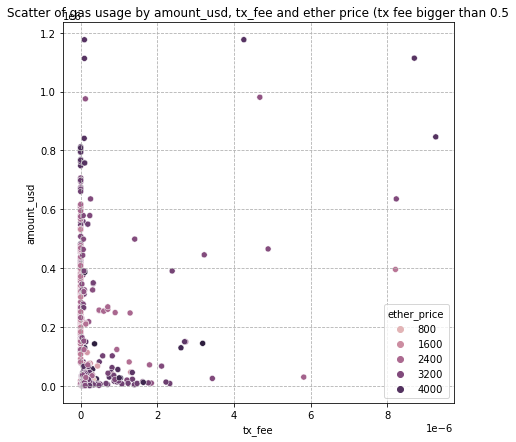

In [15]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['amount_usd'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['ether_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by amount_usd, tx_fee and ether price (tx fee bigger than 0.5')
plt.show()

Once more, all records are more concentrated on lower values of the gas price, meaning that lower gas price stimulates MEV attacks

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


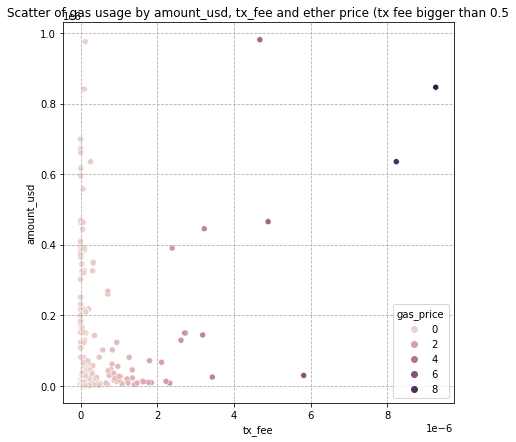

In [16]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['amount_usd'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['gas_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by amount_usd, tx_fee and ether price (tx fee bigger than 0.5')
plt.show()

There are only some unique attackers that are ready to pay higher transaction fees. Those unique cases are going out of the distribution for most of the records and can be seen that some addresses are representing a big number of records. It means that most of the records belong to several addresses. To ensure that, further countplot will be done

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


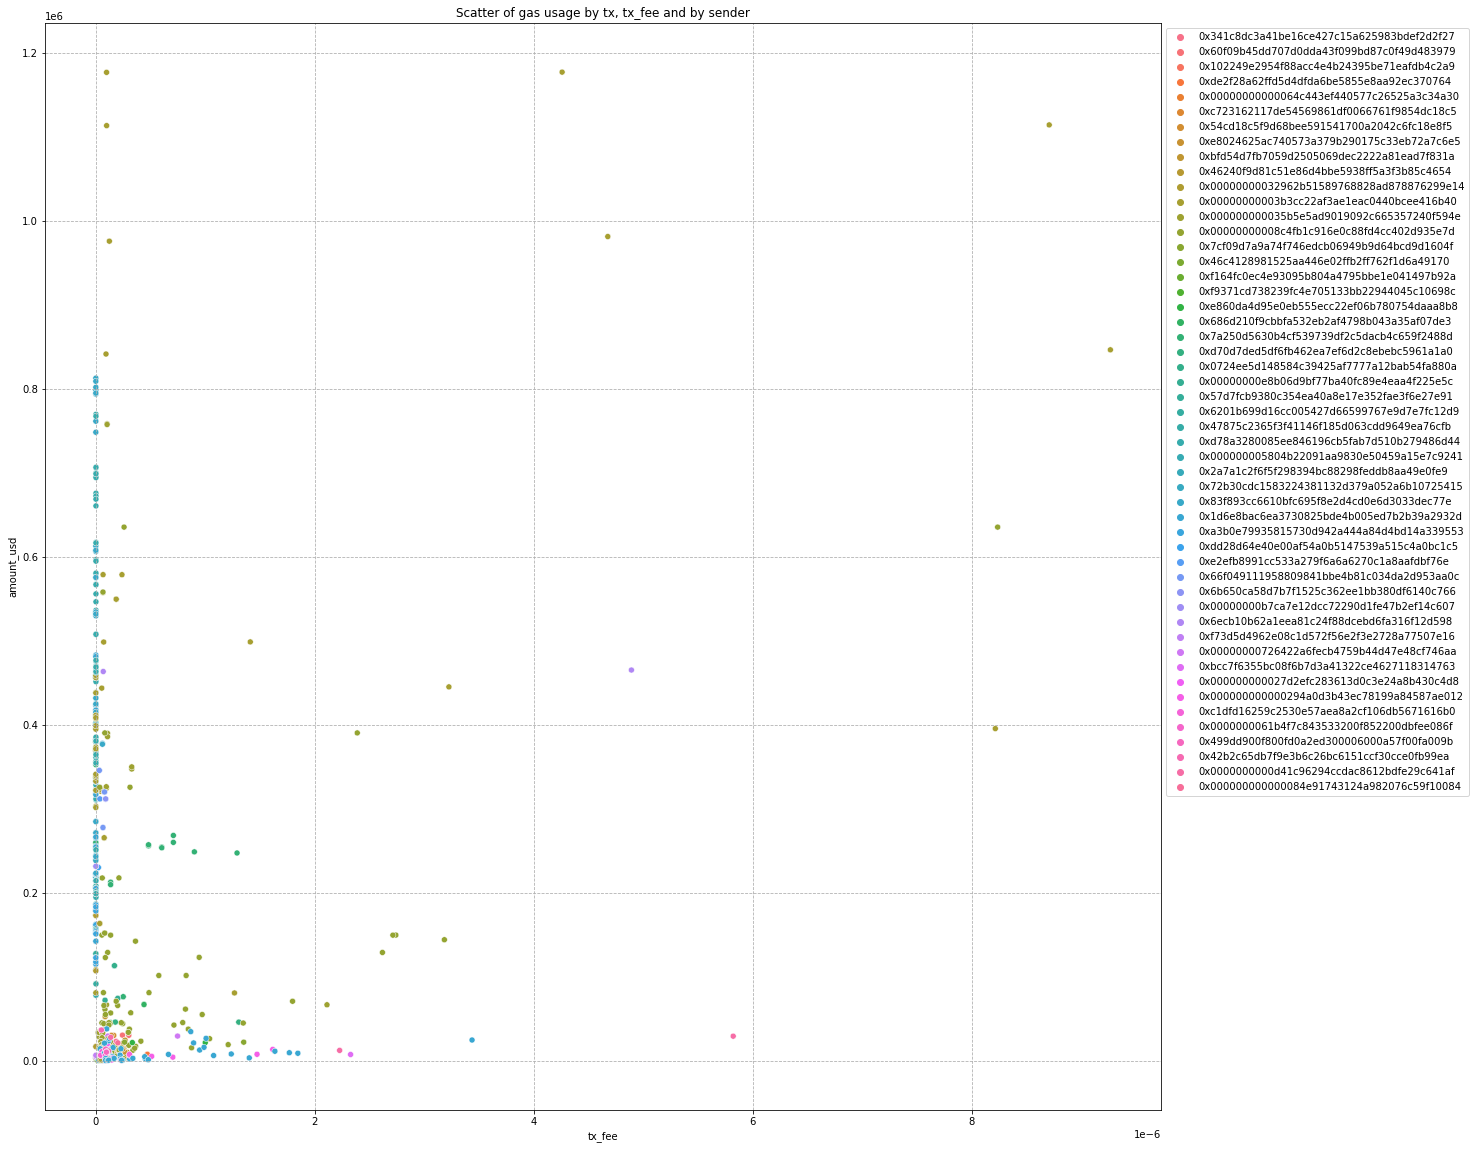

In [17]:
plt.figure(figsize=(20, 20))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['amount_usd'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['sender'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and by sender')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

Only in unique cases attackers are willing to perform transaction with high gas usage and high transaction fees, demonstrating desire for most of the attackers to minimize their losses

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


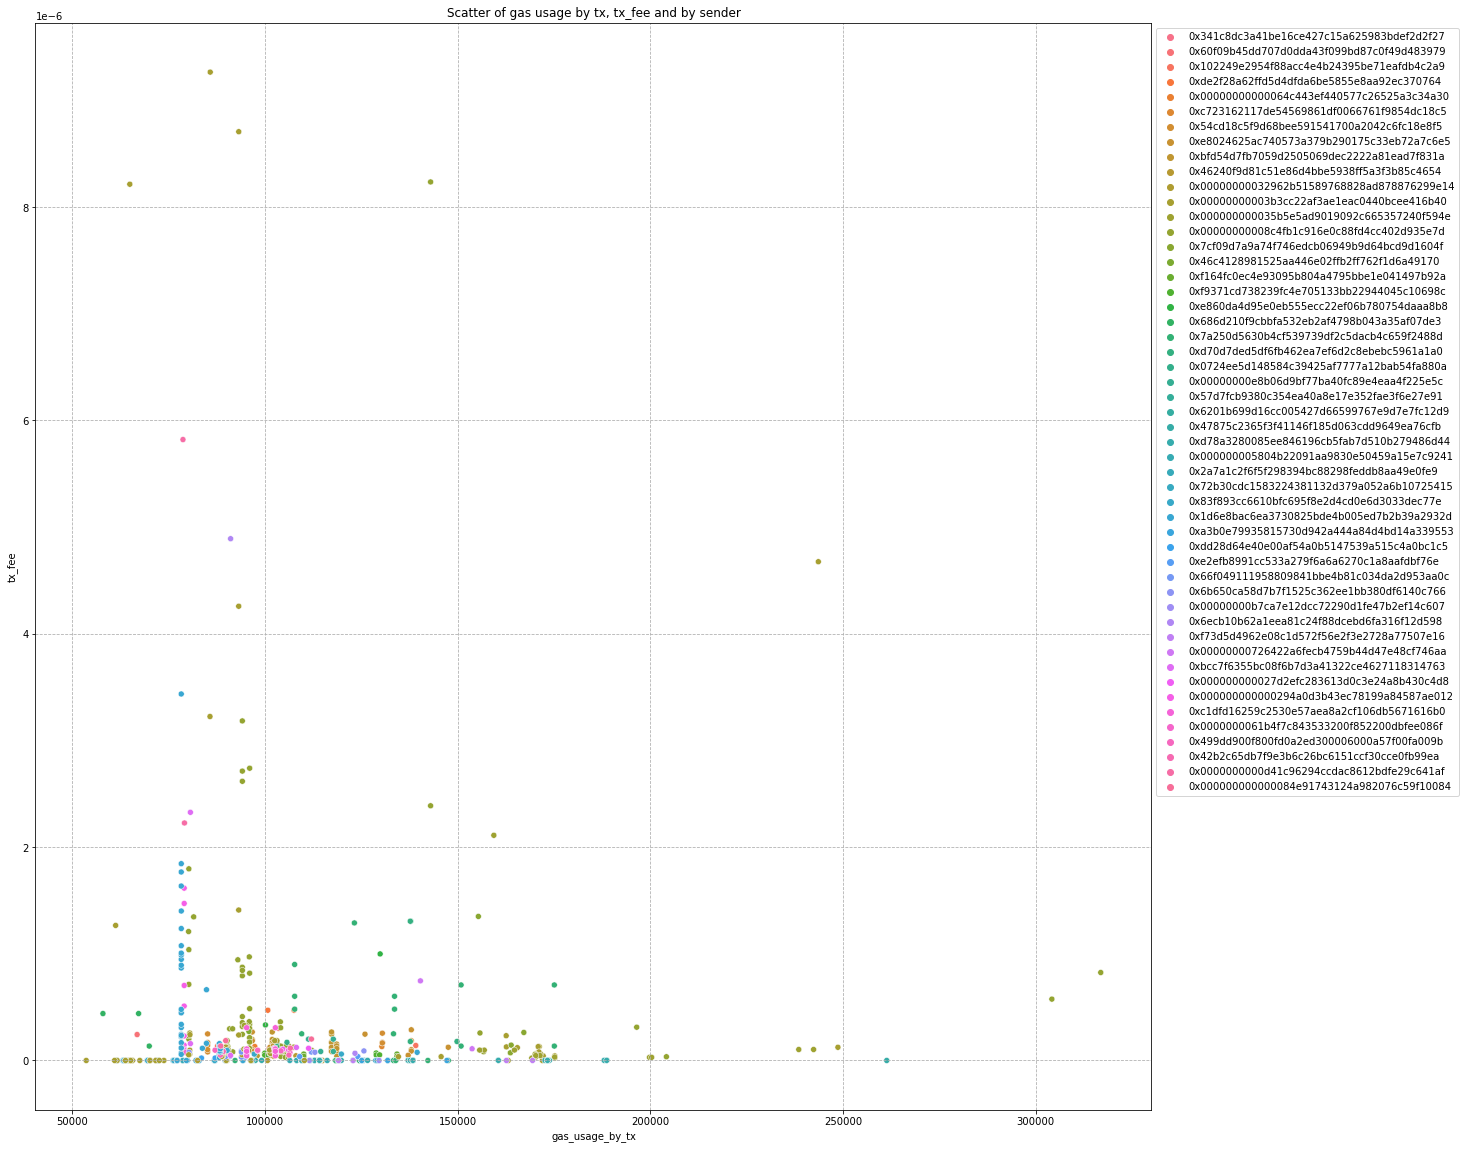

In [18]:
plt.figure(figsize=(20, 20))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['sender'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and by sender')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

In [19]:
mevs_df.sort_values(by=['block'], inplace=True)

In [20]:
mevs_df[mevs_df['tx_fee'] == 1]

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,gas_price,gas_used
226,0x46336e4f9194fa7d412f60c56783c4201c864263648b...,11917692,3,109510,1625.17,1.0,USDC,WETH,83360.918419,51.176754,83633.605938,2021-02-24 04:21:00,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,NaN,NaN
227,0xa2baff0fe50d666e5436647a1a944a487571f02fc448...,11917692,0,133340,1625.17,1.0,WETH,USDC,51.023902,83360.918419,83446.288967,2021-02-24 04:21:00,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7d92ad7e1b6ae22c6a43283af3856028cd3d856a,NaN,NaN
298,0x0572bad13864e29ab7478362118dd1461fbfd5451f95...,12284230,0,138226,2357.59,1.0,WETH,USDC,71.274500,175035.085064,174194.341099,2021-04-21 14:57:02,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
299,0x7f6607c77fb30dce3a1971ce0462dd2b18b55b1170cc...,12284230,2,122414,2357.59,1.0,USDC,WETH,175035.085064,71.570157,174620.836477,2021-04-21 14:57:02,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
303,0xe8121e1611eb0e3c007be5221ad5377c5d24036bf8ea...,12292199,2,122414,2410.48,1.0,USDC,WETH,194123.366917,79.469496,194618.619689,2021-04-22 20:35:32,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
302,0x147fd639305457d7af2f3b1a5fb41a5e9e65f978950d...,12292199,0,138238,2410.48,1.0,WETH,USDC,79.292600,194123.366917,194350.198984,2021-04-22 20:35:32,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
304,0x7a34472d0bee1d4deeaf22a46e9f5241a190d02e029e...,12292710,0,138238,2410.48,1.0,WETH,USDC,81.468700,196790.279501,197217.029681,2021-04-22 22:27:24,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
305,0xf61660433cfca7f9a7dd6a547e8257769c1846b35a4e...,12292710,2,122414,2410.48,1.0,USDC,WETH,196790.279501,82.029677,197988.741335,2021-04-22 22:27:24,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
66,0x8bba445d4bc19f5aa8eec48f5748db2cfca99bdbb80d...,12317226,2,112734,2534.90,1.0,WBTC,USDC,0.972238,53572.033252,53491.929008,2021-04-26 17:10:32,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,1.000000e-18,300000
67,0xaddf9f0aa298bf9b2a3aa6dde88dba8b3b7eea43c5aa...,12317226,0,165920,2534.90,1.0,USDC,WBTC,52333.917800,0.972238,52255.664864,2021-04-26 17:10:32,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,1.000000e-18,400000


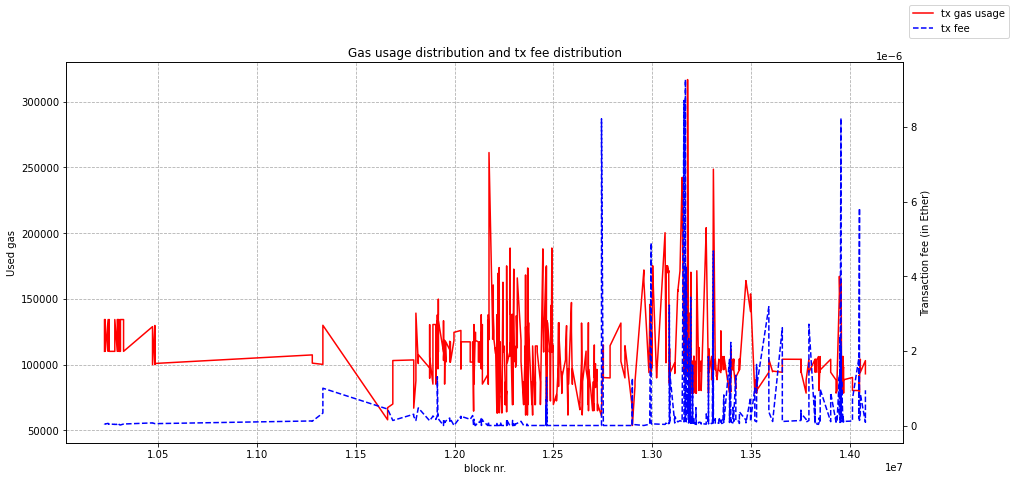

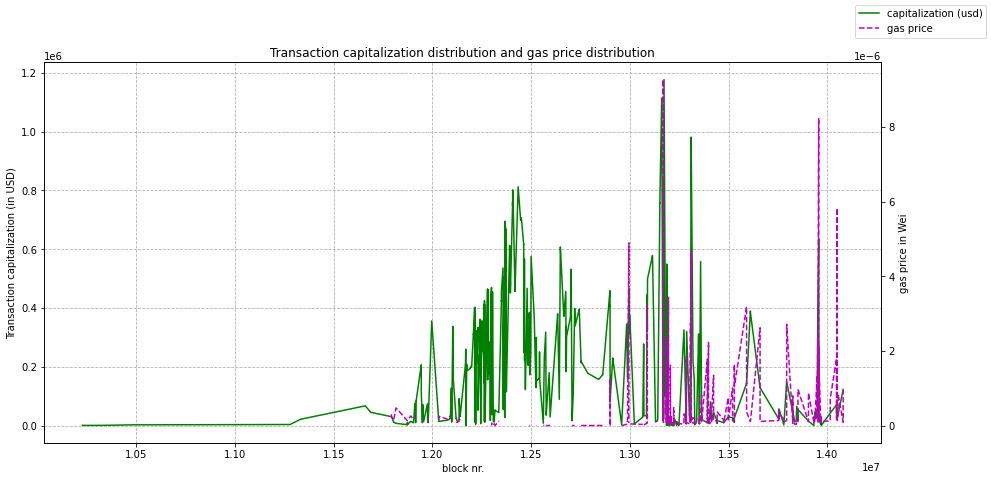

In [21]:
# gas usage and tx fee
fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()

ax.plot(mevs_df['block'], mevs_df['gas_usage_by_tx'], color='r', label='tx gas usage')
ax2.plot(mevs_df[mevs_df['tx_fee'] != 1]['block'], mevs_df[mevs_df['tx_fee'] != 1]['tx_fee'], color='b', linestyle='--', label='tx fee')
ax.set_title('Gas usage distribution and tx fee distribution')
ax.set_xlabel('block nr.')
ax.set_ylabel('Used gas')
ax2.set_ylabel('Transaction fee (in Ether)')

ax.grid(True, linestyle='--')
fig.legend()
plt.show()


# capitalization and gas price
fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()

ax.plot(mevs_df['block'], mevs_df['amount_usd'], color='g', label='capitalization (usd)')
ax2.plot(mevs_df['block'], mevs_df['gas_price'], color='m', linestyle='--', label='gas price')
ax.set_title('Transaction capitalization distribution and gas price distribution')
ax.set_xlabel('block nr.')
ax.set_ylabel('Transaction capitalization (in USD)')
ax2.set_ylabel('gas price in Wei')

ax.grid(True, linestyle='--')
fig.legend()
plt.show()

In most of the cases, MEV transactions are the first and the third ones (which corresponds to the basic attack pattern), but there are some specific cases of attacks happening little later (till position 9). All values above 10-th position are more likely to be outliers.

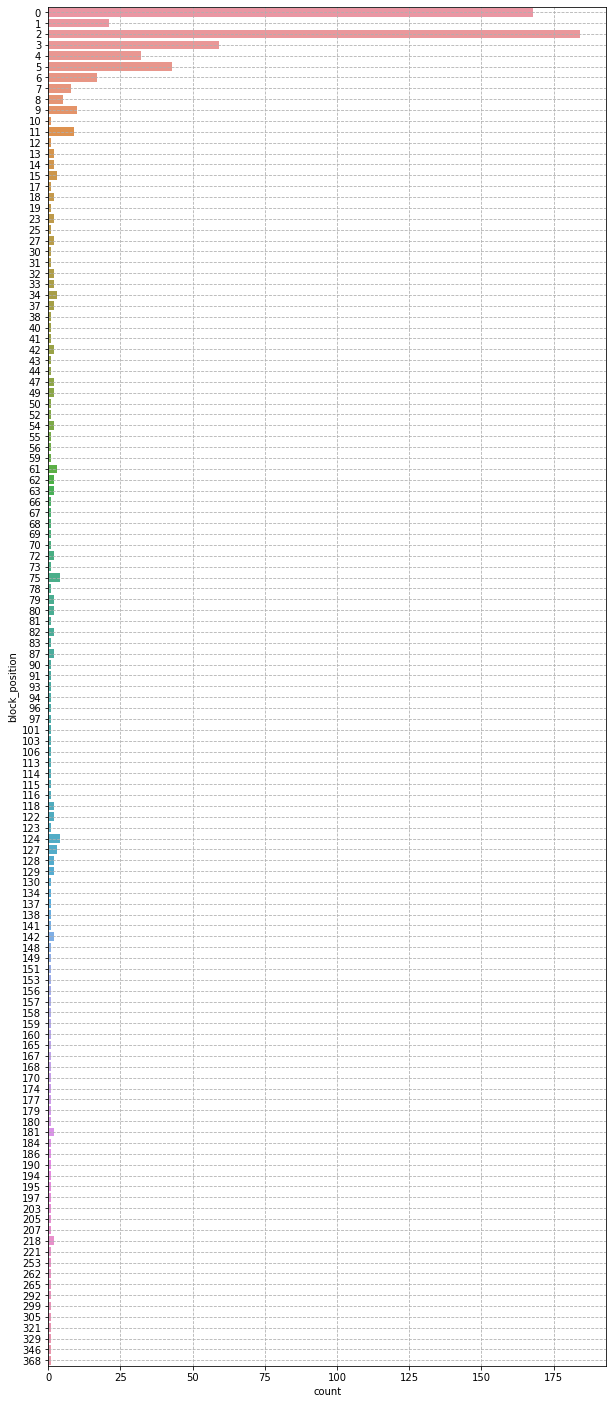

In [22]:
plt.figure(figsize=(10, 25))
sns.countplot(y='block_position', data=mevs_df)
plt.grid(True, linestyle='--')
plt.show()

Even MEV attacks with position in block further than 9-th position are looking like MEV attacks conform their max value, median and mean

In [23]:
print(fr'max capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].max()}')
print(fr'min capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].min()}')
print(fr'mean capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].mean()}')
print(fr'median capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].median()}')


max capitalization registered after 9-th position in the block = 675492.5869615654
min capitalization registered after 9-th position in the block = 326.3228627111209
mean capitalization registered after 9-th position in the block = 43035.864929631505
median capitalization registered after 9-th position in the block = 11693.344351874877


There are several addresses with around 40 MEV attacks performed on the classic tokens pools. On the chart below are presented count of MEV-transactions for all addresses and current chart demonstrates how important it will be to check MEV attack performance over all pools for all addresses, making a blacklist of addresses, their profits and amount of performed attacks

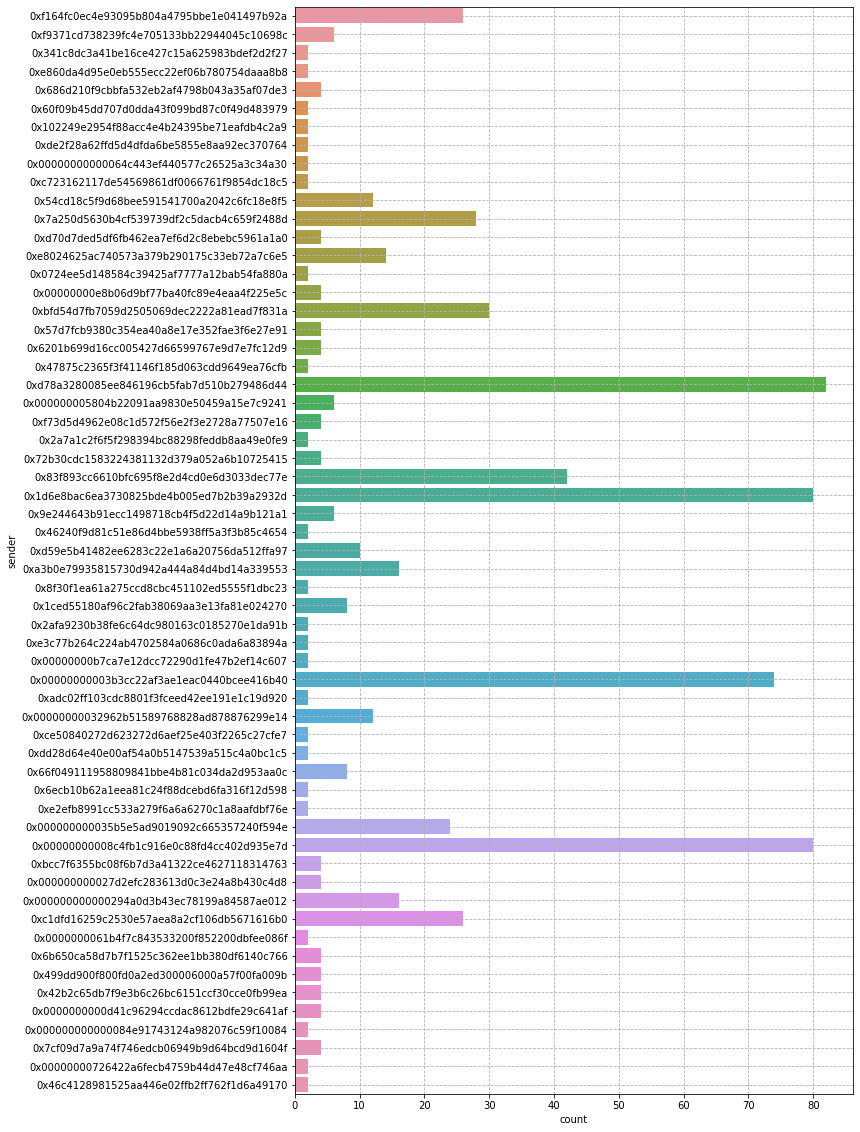

In [24]:
fig = plt.figure(figsize=(10, 20))
sns.countplot(y='sender', data=mevs_df)
plt.grid(True, linestyle='--')
plt.show()

# Separate analysis of all pools

This section provides analysis of the MEVs with exact values match for each of the reviewed pools separately

## General steps

Form Bitcoin and Ether daily prices with transformation of time strings into datetime column.

In [25]:
wbtc_price_df = wbtc_usdc_sim.get_daily_token_price(False, "WBTC")
wbtc_price_df['date'] = wbtc_price_df['date'].dt.strftime("%Y-%m-%d")
weth_price_df = weth_usdc_sim.get_daily_token_price(True, 'WETH')
weth_price_df['date'] = weth_price_df['date'].dt.strftime("%Y-%m-%d")

In [26]:
classic_pools_mevs_df = pd.read_pickle('classic_pools_mevs_with_gas_df.pkl')
classic_pools_mevs_df['txd'] = mevs_transactions_list
classic_pools_mevs_df

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee
0,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,11279366,54,"107,326",478.76,0.000000122000000001
1,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,11279366,62,"101,057",478.76,0.000000115500000001
2,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,11792953,75,"66,799","1,721.48",0.0000002431
3,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,11792953,3,"103,505","1,721.48",0.000000301463842552
4,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,11803970,67,"139,130","1,679.14",0.000000140400000001
...,...,...,...,...,...,...
705,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,13969479,1,"87,023","3,150.83",0.000000096534076405
706,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,13969481,2,"88,383","3,150.83",0.000000109600853456
707,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,13969481,4,"78,261","3,150.83",0.000000117286586847
708,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,"88,481","2,569.59",0.000000135879365521


In [27]:
classic_pools_mevs_df['block'] = pd.to_numeric(classic_pools_mevs_df['block'])
classic_pools_mevs_df['block_position'] = pd.to_numeric(classic_pools_mevs_df['block_position'])
classic_pools_mevs_df['gas_usage_by_tx'] = pd.to_numeric(classic_pools_mevs_df['gas_usage_by_tx'].str.replace(',', ''))
classic_pools_mevs_df['ether_price'] = classic_pools_mevs_df['ether_price'].str.replace('$', '')
classic_pools_mevs_df['ether_price'] = pd.to_numeric(classic_pools_mevs_df['ether_price'].str.replace(',', ''))
classic_pools_mevs_df['tx_fee'] = pd.to_numeric(classic_pools_mevs_df['tx_fee'].str.replace('wei', ''))
classic_pools_mevs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   txd              710 non-null    object 
 1   block            710 non-null    int64  
 2   block_position   710 non-null    int64  
 3   gas_usage_by_tx  710 non-null    int64  
 4   ether_price      710 non-null    float64
 5   tx_fee           710 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 33.4+ KB


<ipython-input-27-38a694d466e2>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  classic_pools_mevs_df['ether_price'] = classic_pools_mevs_df['ether_price'].str.replace('$', '')


In [28]:
wbtc_usdc_swaps_df = wbtc_usdc_sim.get_original_swaps_df()
weth_usdc_swaps_df = weth_usdc_sim.get_original_swaps_df()
wbtc_dai_swaps_df = wbtc_dai_sim.get_original_swaps_df()
fei_weth_swaps_df = fei_weth_sim.get_original_swaps_df()
hkmt_usdt_swaps_df = hkmt_usdt_sim.get_original_swaps_df()
ixs_weth_swaps_df = ixs_weth_sim.get_original_swaps_df()

## WBTC/USDC

There are 91 MEV attacks catched by the algorithm out of the 69834 transactions.

In [29]:
wbtc_usdc_filtered_swaps_df, wbtc_usdc_mevs_df = wbtc_usdc_sim.extract_filtered_and_mevs_dfs()
wbtc_usdc_mevs_df

initial len = 69834, filtered len = 69652
txds = 182
out values = 91


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used
4088,USDC,WBTC,3694.507910,0.209063,3684.217300,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,122000000001,118777
4089,WBTC,USDC,0.207678,3694.507910,3692.331147,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,115500000001,125946
30365,WBTC,USDC,0.814765,30511.102171,30517.868246,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,243100000000,350000
30366,USDC,WBTC,30305.000000,0.814765,30311.720370,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,301463842552,230000
31182,WBTC,USDC,0.288400,11703.050959,11693.344352,2021-02-06 16:53:21,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,140400000001,290000
...,...,...,...,...,...,...,...,...,...,...,...
69516,WBTC,USDC,2.217007,66597.165318,66618.778349,2022-01-07 07:12:04,0x000000000035b5e5ad9019092c665357240f594e,0x000000000035b5e5ad9019092c665357240f594e,0x9bafde259884a8e6081a596162ac0df2ffe76a106d8f...,97745263744,264733
69538,USDC,WBTC,3542.772183,0.087565,3544.342088,2022-01-08 16:48:06,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x156466a69601ac3f7a111b4870359faaa72aed70dd15...,272463299446,198610
69539,WBTC,USDC,0.087565,3679.387499,3681.017943,2022-01-08 16:48:06,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0xa86ae972dffe4cbaed34680865621458d291ebe74c4a...,96958937586,209045
69702,USDC,WBTC,37711.479807,1.286411,37647.553852,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x94fff3ef66ab898bb1afbb9128da1ce611cc45a592ab...,844654862110,164705


After collecting all the data is performed series of steps to calculate profits:
* Transformation of the ```date``` (or ```timestamp```) column into datetime format;
* Connecting WETH (all of the cases) and WBTC (current case) tokens price distributions to the possible MEVs data;
* Transform profits of the first token into stablecoin (price relative close to USD) or into Ether;
* Connect profit from first token with profit from the second token. If first and second are transformed into stablecoin - this means relatively close estimation to the USD. Otherwise, result must be multiplied by Ether current day price;
* Perform transformation of outliers in ```tx_fee``` column (possible error during extraction process);
* Find gas costs for the attacker in USD via multiplication of the transaction fee with Ether price and amount of used by transaction gas;
* Calculate netto profit via negation of found gas costs in USD from bruto total profit

In [30]:
wbtc_usdc_mevs_df = wbtc_usdc_sim.calculate_attack_profit(wbtc_usdc_mevs_df)
wbtc_usdc_mevs_df = wbtc_usdc_sim.calculate_attack_profit_by_token(wbtc_usdc_mevs_df)

In [31]:
wbtc_usdc_mevs_df['date'] = wbtc_usdc_mevs_df['timestamp'].dt.strftime("%Y-%m-%d")
wbtc_usdc_mevs_df = pd.merge(wbtc_usdc_mevs_df, wbtc_price_df, on='date', how='left')
wbtc_usdc_mevs_df = pd.merge(wbtc_usdc_mevs_df, weth_price_df, on='date', how='left')
wbtc_usdc_mevs_df = pd.merge(wbtc_usdc_mevs_df, classic_pools_mevs_df, on='txd', how='left')

### Brutto and netto profit calculation

In [32]:
wbtc_usdc_mevs_df['bruto_wbtc_to_usdc_profit'] = wbtc_usdc_mevs_df['WBTC_profit'] * wbtc_usdc_mevs_df['WBTC_price']
wbtc_usdc_mevs_df['bruto_total_profit'] = wbtc_usdc_mevs_df['bruto_wbtc_to_usdc_profit'] + wbtc_usdc_mevs_df['USDC_profit']
wbtc_usdc_mevs_df.loc[wbtc_usdc_mevs_df['tx_fee'] >= 1, 'tx_fee'] = wbtc_usdc_mevs_df['tx_fee'].median()
wbtc_usdc_mevs_df.loc[wbtc_usdc_mevs_df['tx_fee'] == 0, 'tx_fee'] = wbtc_usdc_mevs_df['tx_fee'].median()
wbtc_usdc_mevs_df['gas_costs_usd'] = (wbtc_usdc_mevs_df['tx_fee'] * wbtc_usdc_mevs_df['WETH_price'] *
                                      wbtc_usdc_mevs_df['gas_usage_by_tx'])
wbtc_usdc_mevs_df['netto_profit'] = wbtc_usdc_mevs_df['bruto_total_profit'] - wbtc_usdc_mevs_df['gas_costs_usd']
wbtc_usdc_mevs_df.dropna(inplace=True)
wbtc_usdc_mevs_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,USDC,WBTC,3694.507910,0.209063,3684.217300,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,122000000001,...,480.797681,11279366,54,107326,478.76,1.220000e-07,24.758508,24.758508,6.295455,18.463053
1,WBTC,USDC,0.207678,3694.507910,3692.331147,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,115500000001,...,480.797681,11279366,62,101057,478.76,1.155000e-07,24.758508,24.758508,5.611911,19.146597
2,WBTC,USDC,0.814765,30511.102171,30517.868246,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,243100000000,...,1717.991364,11792953,75,66799,1721.48,2.431000e-07,0.000000,206.102171,27.898182,178.203989
3,USDC,WBTC,30305.000000,0.814765,30311.720370,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,301463842552,...,1717.991364,11792953,3,103505,1721.48,3.014638e-07,0.000000,206.102171,53.606510,152.495661
4,WBTC,USDC,0.288400,11703.050959,11693.344352,2021-02-06 16:53:21,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,140400000001,...,1682.430433,11803970,67,139130,1679.14,1.404000e-07,109.058743,109.058743,32.864347,76.194396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,WBTC,USDC,2.217007,66597.165318,66618.778349,2022-01-07 07:12:04,0x000000000035b5e5ad9019092c665357240f594e,0x000000000035b5e5ad9019092c665357240f594e,0x9bafde259884a8e6081a596162ac0df2ffe76a106d8f...,97745263744,...,3187.113198,13956896,0,164733,3196.47,9.774526e-08,1245.039447,1245.039447,51.318484,1193.720963
190,USDC,WBTC,3542.772183,0.087565,3544.342088,2022-01-08 16:48:06,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x156466a69601ac3f7a111b4870359faaa72aed70dd15...,272463299446,...,3090.354178,13965925,4,95810,3080.81,2.724633e-07,0.000000,136.615316,80.672796,55.942520
191,WBTC,USDC,0.087565,3679.387499,3681.017943,2022-01-08 16:48:06,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0xa86ae972dffe4cbaed34680865621458d291ebe74c4a...,96958937586,...,3090.354178,13965925,2,106245,3080.81,9.695894e-08,0.000000,136.615316,31.834982,104.780334
192,USDC,WBTC,37711.479807,1.286411,37647.553852,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x94fff3ef66ab898bb1afbb9128da1ce611cc45a592ab...,844654862110,...,2405.015219,14054109,3,94113,2412.23,8.446549e-07,345.926450,345.926450,191.181882,154.744568


There are some problems during concatenation and merge processes, when algorithm somehow duplicates elements of the dataset and to ensure save of real data without repeats it is required to perform ```drop_duplicates()```

In [33]:
print(len(wbtc_usdc_mevs_df))
wbtc_usdc_mevs_df.drop_duplicates(subset=["timestamp", "amount_in", "txd", "block", "block_position"], inplace=True)
print(len(wbtc_usdc_mevs_df))
wbtc_usdc_mevs_df

194
182


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,USDC,WBTC,3694.507910,0.209063,3684.217300,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,122000000001,...,480.797681,11279366,54,107326,478.76,1.220000e-07,24.758508,24.758508,6.295455,18.463053
1,WBTC,USDC,0.207678,3694.507910,3692.331147,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,115500000001,...,480.797681,11279366,62,101057,478.76,1.155000e-07,24.758508,24.758508,5.611911,19.146597
2,WBTC,USDC,0.814765,30511.102171,30517.868246,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,243100000000,...,1717.991364,11792953,75,66799,1721.48,2.431000e-07,0.000000,206.102171,27.898182,178.203989
3,USDC,WBTC,30305.000000,0.814765,30311.720370,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,301463842552,...,1717.991364,11792953,3,103505,1721.48,3.014638e-07,0.000000,206.102171,53.606510,152.495661
4,WBTC,USDC,0.288400,11703.050959,11693.344352,2021-02-06 16:53:21,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,140400000001,...,1682.430433,11803970,67,139130,1679.14,1.404000e-07,109.058743,109.058743,32.864347,76.194396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,WBTC,USDC,2.217007,66597.165318,66618.778349,2022-01-07 07:12:04,0x000000000035b5e5ad9019092c665357240f594e,0x000000000035b5e5ad9019092c665357240f594e,0x9bafde259884a8e6081a596162ac0df2ffe76a106d8f...,97745263744,...,3187.113198,13956896,0,164733,3196.47,9.774526e-08,1245.039447,1245.039447,51.318484,1193.720963
190,USDC,WBTC,3542.772183,0.087565,3544.342088,2022-01-08 16:48:06,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x156466a69601ac3f7a111b4870359faaa72aed70dd15...,272463299446,...,3090.354178,13965925,4,95810,3080.81,2.724633e-07,0.000000,136.615316,80.672796,55.942520
191,WBTC,USDC,0.087565,3679.387499,3681.017943,2022-01-08 16:48:06,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0x46c4128981525aa446e02ffb2ff762f1d6a49170,0xa86ae972dffe4cbaed34680865621458d291ebe74c4a...,96958937586,...,3090.354178,13965925,2,106245,3080.81,9.695894e-08,0.000000,136.615316,31.834982,104.780334
192,USDC,WBTC,37711.479807,1.286411,37647.553852,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x94fff3ef66ab898bb1afbb9128da1ce611cc45a592ab...,844654862110,...,2405.015219,14054109,3,94113,2412.23,8.446549e-07,345.926450,345.926450,191.181882,154.744568


### Amount of bigger sandwiches and profits

In [34]:
wbtc_usdc_count_df = wbtc_usdc_mevs_df.value_counts(subset=['timestamp'])
wbtc_usdc_count_df[wbtc_usdc_count_df.values > 2]

timestamp          
2021-03-13 18:13:39    4
2021-04-04 02:21:56    4
2021-02-17 09:41:36    4
dtype: int64

In case of looking into those transactions forming double sandwiches can be seen that there are two attacks catched inside of the one block. Another interesting moment is that presented cases show that attackers not always set their attacks to the positions in the beginning of block

In [35]:
wbtc_usdc_mevs_df[wbtc_usdc_mevs_df['timestamp'] == datetime.fromisoformat("2021-03-13 18:13:39")]

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
30,USDC,WBTC,14009.284827,0.232488,13984.436223,2021-03-13 18:13:39,0xbfd54d7fb7059d2505069dec2222a81ead7f831a,0xbfd54d7fb7059d2505069dec2222a81ead7f831a,0x28e4bd801dc990bb1cb83052e90b0be2dbbaab1a895f...,246777283680,...,1926.53404,12031806,9,117270,1921.18,2.467773e-07,0.0,371.614630,55.753071,315.861559
32,WBTC,USDC,0.232488,14380.899457,14355.391711,2021-03-13 18:13:39,0xbfd54d7fb7059d2505069dec2222a81ead7f831a,0xbfd54d7fb7059d2505069dec2222a81ead7f831a,0x3d56f0f1bde5b3d67cca378f4a91e68f98fc21109d89...,197000000000,...,1926.53404,12031806,114,101865,1921.18,1.970000e-07,0.0,371.614630,38.660539,332.954091
34,WBTC,USDC,0.345341,21093.458426,21056.044454,2021-03-13 18:13:39,0xe8024625ac740573a379b290175c33eb72a7c6e5,0x722a8de5fcbe9838d9f2cc52b4610a8edcbd36ba,0xb0629c1a499d3e0380335fcc73645dc23f1ade2bef5c...,197000000000,...,1926.53404,12031806,116,96687,1921.18,1.970000e-07,0.0,93.458426,36.695347,56.763079
36,USDC,WBTC,21000.000000,0.345341,20962.751797,2021-03-13 18:13:39,0xe8024625ac740573a379b290175c33eb72a7c6e5,0x722a8de5fcbe9838d9f2cc52b4610a8edcbd36ba,0xff416ed540ba3ae3fa36ea5c8f3cc64cbf93794bfb6a...,246777283568,...,1926.53404,12031806,10,125940,1921.18,2.467773e-07,0.0,93.458426,59.875004,33.583422


In [36]:
wbtc_usdc_mevs_df[wbtc_usdc_mevs_df['timestamp'] == datetime.fromisoformat("2021-04-04 02:21:56")]

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
54,WBTC,USDC,0.206640,11966.683517,11971.859522,2021-04-04 02:21:56,0xe8024625ac740573a379b290175c33eb72a7c6e5,0x722a8de5fcbe9838d9f2cc52b4610a8edcbd36ba,0x19d8da09df9dcd4f36901565efe08fd56ba1f823f201...,101200000000,...,2062.846796,12170399,205,96687,2076.62,1.012000e-07,0.0,128.101834,20.184387,107.917447
56,USDC,WBTC,623.083247,0.010849,623.352752,2021-04-04 02:21:56,0x54cd18c5f9d68bee591541700a2042c6fc18e8f5,0x54cd18c5f9d68bee591541700a2042c6fc18e8f5,0x33b1907c8010b0d57c50c0a14ae95c09c513805cc41b...,101200000001,...,2062.846796,12170399,124,118431,2076.62,1.012000e-07,0.0,6.746071,24.723667,-17.977596
58,WBTC,USDC,0.010849,629.829318,630.101741,2021-04-04 02:21:56,0x54cd18c5f9d68bee591541700a2042c6fc18e8f5,0x54cd18c5f9d68bee591541700a2042c6fc18e8f5,0x541aec94e635e59fbde24c66a3b3f36eb4b179e33231...,101200000000,...,2062.846796,12170399,203,85096,2076.62,1.012000e-07,0.0,6.746071,17.764649,-11.018578
60,USDC,WBTC,11838.581683,0.206640,11843.702279,2021-04-04 02:21:56,0xe8024625ac740573a379b290175c33eb72a7c6e5,0x722a8de5fcbe9838d9f2cc52b4610a8edcbd36ba,0x8b7e6115df6eb1a67f93061ebfd037be24a185f791d6...,101200000002,...,2062.846796,12170399,123,137956,2076.62,1.012000e-07,0.0,128.101834,28.799708,99.302126


In [37]:
wbtc_usdc_mevs_df[wbtc_usdc_mevs_df['timestamp'] == datetime.fromisoformat("2021-02-17 09:41:36")]

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
8,USDC,WBTC,3118.393506,0.060407,3117.234533,2021-02-17 09:41:36,0x00000000000064c443ef440577c26525a3c34a30,0x00000000000064c443ef440577c26525a3c34a30,0x7d2c2fe3e17ae75a4c876b04c53e05b76c56fd137d93...,130718281829,...,1844.672543,11873591,149,97347,1851.14,1.307183e-07,27.399776,27.399776,23.473518,3.926258
10,WBTC,USDC,0.194148,10087.641426,10083.768205,2021-02-17 09:41:36,0xc723162117de54569861df0066761f9854dc18c5,0xc723162117de54569861df0066761f9854dc18c5,0xb28a5acc0aaf52bfaf703660747c73120221820375f8...,127000000000,...,1844.672543,11873591,181,89676,1851.14,1.270000e-07,0.000000,87.641426,21.008703,66.632723
12,USDC,WBTC,10000.000000,0.194148,9996.283430,2021-02-17 09:41:36,0xc723162117de54569861df0066761f9854dc18c5,0xc723162117de54569861df0066761f9854dc18c5,0xb8b877f6f682d25cad587b9020b81c764cc260d02014...,130718284315,...,1844.672543,11873591,148,130318,1851.14,1.307183e-07,0.000000,87.641426,31.423896,56.217530
14,WBTC,USDC,0.059882,3118.393506,3117.196177,2021-02-17 09:41:36,0x00000000000064c443ef440577c26525a3c34a30,0x00000000000064c443ef440577c26525a3c34a30,0xf3bb65218973e4d508d01c8070bc31621ba619dd676b...,127000000000,...,1844.672543,11873591,179,105736,1851.14,1.270000e-07,27.399776,27.399776,24.771134,2.628642


Highest registered profit out of the MEV attack demonstrates that compared to the capitalization of pool activity it is relatively low and therefore attackers activity is on low-medium level depending on the trades activity.

In [38]:
grouped_wbtc_usdc_profits_df = wbtc_usdc_mevs_df.groupby(by=['timestamp']).sum()
grouped_wbtc_usdc_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_wbtc_usdc_profits_df['block'] = grouped_wbtc_usdc_profits_df['block'] / 2
grouped_wbtc_usdc_profits_df['bruto_total_profit'] = grouped_wbtc_usdc_profits_df['bruto_total_profit']/2
grouped_wbtc_usdc_profits_df['netto_profit'] = (grouped_wbtc_usdc_profits_df['bruto_total_profit'] -
                                                grouped_wbtc_usdc_profits_df['gas_costs_usd'])
grouped_wbtc_usdc_profits_df.reset_index(inplace=True)

print(fr"max brutto profit {grouped_wbtc_usdc_profits_df['bruto_total_profit'].max()}")
print(fr"min brutto profit {grouped_wbtc_usdc_profits_df['bruto_total_profit'].min()}")
print(fr"max netto profit {grouped_wbtc_usdc_profits_df['netto_profit'].max()}")
print(fr"min netto profit {grouped_wbtc_usdc_profits_df['netto_profit'].min()}")
print(fr"zero bruto profit transactions = {len(wbtc_usdc_mevs_df[wbtc_usdc_mevs_df['bruto_total_profit'] == 0])}")
print(fr"transactions with losses = {len(wbtc_usdc_mevs_df[wbtc_usdc_mevs_df['netto_profit'] < 0])}")

max brutto profit 7153.688134529131
min brutto profit 0.3840810000001511
max netto profit 7098.724081420283
min netto profit -129.32933568232542
zero bruto profit transactions = 0
transactions with losses = 11


Total extracted profit brutto/netto is extremely low compared to the pool capitalization and amount of paid gas is extremely high - it is almost 1/3 out of the brutto profit, meaning that in current case gas has high impact on attackers.

In [39]:
print(fr"sum of paid gas = {sum(wbtc_usdc_mevs_df['gas_costs_usd'])}")
print(fr"sum of brutto profits = {sum(wbtc_usdc_mevs_df['bruto_total_profit'] / 2)}")
print(fr"sum of netto profits = {sum(wbtc_usdc_mevs_df['bruto_total_profit'] / 2) - sum(wbtc_usdc_mevs_df['gas_costs_usd'])}")

sum of paid gas = 17748.324905675763
sum of brutto profits = 57938.64642589289
sum of netto profits = 40190.32152021713


To show how low is impact of the attackers on the presented pool it is required to consider total capitalization of the pool. There will be two variants: one with capitalization estimated by the internal Uniswap services; another one, estimated basing on tokens in transactions and their current price transformed to the stablecoins.

### Brutto profit to Uniswap capitalization coefficient

In [40]:
print("brutto attacks profits (" + str(sum(wbtc_usdc_mevs_df['bruto_total_profit'] / 2)) +
      ") to WBTC/USDC Uniswap capitalization (" + str(wbtc_usdc_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(wbtc_usdc_mevs_df['bruto_total_profit'] / 2) / wbtc_usdc_swaps_df['amount_usd'].sum()))

brutto attacks profits (57938.64642589289) to WBTC/USDC Uniswap capitalization (423661985.7594432) coef is equal to 0.00013675677396930925


### Brutto profit to custom capitalization coefficient

It is important to perform manual check of the first token value and second token value, considering that it is not possible to set correct token name from the start and requiring manual check of values

In [41]:
wbtc_usdc_swaps_df = wbtc_usdc_sim.calculate_attack_profit_by_token(wbtc_usdc_swaps_df)
wbtc_usdc_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used,first_token_value,second_token_value,USDC_profit,WBTC_profit
0,USDC,WBTC,1.534170e-01,0.000016,0.152773,2020-05-19 23:44:23,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x3da4491fed9f6d6b1391b2a02991c8d035d7716f,0xba9a47ed6b7d293da7e7643f434055ff76bdf609274f...,16500000000,2696317,0.153417,1.575000e-05,0.0,0.0
1,WBTC,USDC,2.501000e-04,2.367365,2.371854,2020-05-21 14:39:56,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0xffff2870fd0aa2f909766844c95f53b83625854c925e...,65666700000,2199596,2.367365,2.501000e-04,0.0,0.0
2,WBTC,USDC,1.047330e-03,9.603013,9.593976,2020-05-22 20:47:02,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x68e9800197efaafee864d33cf6167d12e4aa29a527c9...,25300000000,1961488,9.603013,1.047330e-03,0.0,0.0
3,USDC,WBTC,8.923190e-01,0.000098,0.891249,2020-05-23 14:00:42,0x0d4743269fec611b422d0a209a460cd8cc0cc8b9,0x0d4743269fec611b422d0a209a460cd8cc0cc8b9,0x33fbec2e6e1a3a04a1f5109f3a8809f32c7ad7e75c7d...,35640000000,1586338,0.892319,9.756000e-05,0.0,0.0
4,WBTC,USDC,1.100000e-07,0.001000,0.000995,2020-05-24 17:37:32,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x211b6a1137bf539b2750e02b9e525cf5757a35ae,0x273375cad4d5cf584b70af639f3cf07a53ba00a07216...,31000010000,139738,0.001000,1.100000e-07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69829,USDC,WBTC,2.000000e+03,0.053648,1998.400208,2022-01-26 03:54:09,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x7e2b8aa127f6a50715ed4d300a95e6d1d35fd08a,0xf697f284a8b119c7ebeea5348ac39ce4f29cb467d007...,123992019338,296836,2000.000000,5.364782e-02,0.0,0.0
69830,USDC,WBTC,2.475000e+03,0.065177,2477.867510,2022-01-26 07:10:38,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x7e2b8aa127f6a50715ed4d300a95e6d1d35fd08a,0x3aca4a3b571af7dfc6ff33021089b446ad4681f35df1...,113912631059,616360,2475.000000,6.517665e-02,0.0,0.0
69831,WBTC,USDC,8.852110e-02,3329.544519,3333.297668,2022-01-26 07:11:18,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,0xeef86c2e49e11345f1a693675df9a38f7d880c8f,0x2eb25abddad0bf49bb8ccc78c4402ae2ad5f167274cc...,89051920482,296947,3329.544519,8.852110e-02,0.0,0.0
69832,WBTC,USDC,4.698974e-02,1730.792534,1730.585888,2022-01-26 07:39:15,0xd7c09e006a2891880331b0f6224071c1e890a98a,0xd7c09e006a2891880331b0f6224071c1e890a98a,0x6b193a8d0434a72520dae03dc4fee82f22dcceec0eaa...,115830894534,385237,1730.792534,4.698974e-02,0.0,0.0


In [42]:
wbtc_usdc_swaps_df['date'] = wbtc_usdc_swaps_df['timestamp'].dt.strftime("%Y-%m-%d")
wbtc_usdc_swaps_df = pd.merge(wbtc_usdc_swaps_df, wbtc_price_df, on='date', how='left')
wbtc_usdc_swaps_df = pd.merge(wbtc_usdc_swaps_df, weth_price_df, on='date', how='left')
wbtc_usdc_swaps_df['cap_wbtc_to_usdc'] = wbtc_usdc_swaps_df['second_token_value'] * wbtc_usdc_swaps_df['WBTC_price']
wbtc_usdc_swaps_df['total_cap'] = wbtc_usdc_swaps_df['cap_wbtc_to_usdc'] + wbtc_usdc_swaps_df['first_token_value']

In [43]:
print("brutto attacks profits (" + str(sum(wbtc_usdc_mevs_df['bruto_total_profit'] / 2)) +
      ") to WBTC/USDC custom capitalization (" + str(wbtc_usdc_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(wbtc_usdc_mevs_df['bruto_total_profit'] / 2) / wbtc_usdc_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (57938.64642589289) to WBTC/USDC custom capitalization (424803726.8353437) coef is equal to 3.4097303510916604e-05


### Netto profit to Uniswap capitalization coefficient

In [44]:
print("brutto attacks profits (" + str(sum(wbtc_usdc_mevs_df['netto_profit'] / 2)) +
      ") to WBTC/USDC Uniswap capitalization (" + str(wbtc_usdc_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(wbtc_usdc_mevs_df['netto_profit'] / 2) / wbtc_usdc_swaps_df['amount_usd'].sum()))

brutto attacks profits (49064.48397305502) to WBTC/USDC Uniswap capitalization (423661985.7594432) coef is equal to 0.00011581044705982664


### Netto profit to custom capitalization coefficient

In [45]:
print("brutto attacks profits (" + str(sum(wbtc_usdc_mevs_df['netto_profit'] / 2)) +
      ") to WBTC/USDC custom capitalization (" + str(wbtc_usdc_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(wbtc_usdc_mevs_df['netto_profit'] / 2) / wbtc_usdc_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (49064.48397305502) to WBTC/USDC custom capitalization (424803726.8353437) coef is equal to 2.887479609617025e-05


### MEV transactions frequency to standard transactions

MEVs frequency is extremely small and can be seen that there is almost no MEV activity registered in such a big pool

In [46]:
print("WBTC/USDC pool contains " + str(len(wbtc_usdc_mevs_df) / 2) + " MEV attacks (or " +
      str(len(wbtc_usdc_mevs_df)) + " MEV transactions) out of " + str(len(wbtc_usdc_swaps_df)) +
      " total transactions." +
      "\nCoefficient of MEV attacks = " + str((len(wbtc_usdc_mevs_df) / 2) / len(wbtc_usdc_swaps_df)) +
      "; coefficient of MEV transactions = " + str(len(wbtc_usdc_mevs_df) / len(wbtc_usdc_swaps_df)) +
      "\nCoef of MEV attacks cap = " + str(wbtc_usdc_mevs_df['amount_usd'].sum() / wbtc_usdc_swaps_df['amount_usd'].sum()))

WBTC/USDC pool contains 91.0 MEV attacks (or 182 MEV transactions) out of 69834 total transactions.
Coefficient of MEV attacks = 0.0013030901852965605; coefficient of MEV transactions = 0.002606180370593121
Coef of MEV attacks cap = 0.026681939218553608


### Distribution of profits and capitalizations

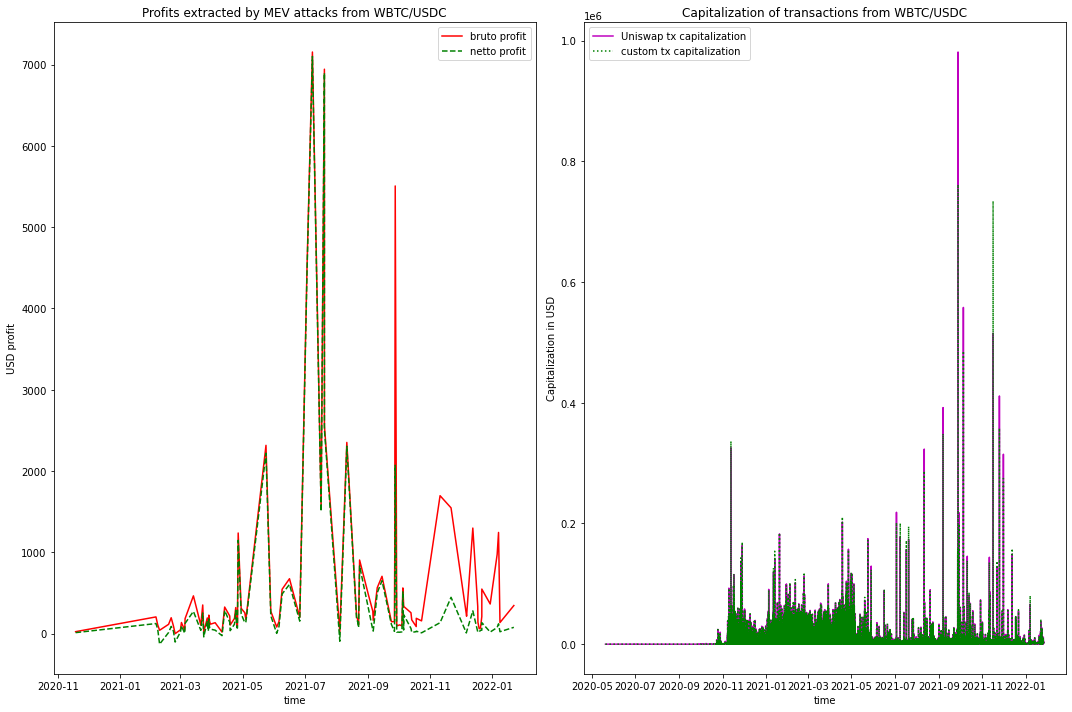

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.plot(grouped_wbtc_usdc_profits_df['timestamp'], grouped_wbtc_usdc_profits_df['bruto_total_profit'], label='bruto profit', color='r')
ax1.plot(grouped_wbtc_usdc_profits_df['timestamp'], grouped_wbtc_usdc_profits_df['netto_profit'], label='netto profit', color='g', linestyle='--')
ax1.set_xlabel('time')
ax1.set_ylabel('USD profit')
ax1.set_title('Profits extracted by MEV attacks from WBTC/USDC')
ax1.legend()

ax2.plot(wbtc_usdc_swaps_df['timestamp'], wbtc_usdc_swaps_df['amount_usd'], label="Uniswap tx capitalization", color='m')
ax2.plot(wbtc_usdc_swaps_df['timestamp'], wbtc_usdc_swaps_df['total_cap'] / 2, label="custom tx capitalization", color='g',
         linestyle=':')
ax2.set_xlabel('time')
ax2.set_ylabel('Capitalization in USD')
ax2.set_title('Capitalization of transactions from WBTC/USDC')
ax2.legend()

plt.tight_layout()
plt.show()

## WETH/USDC

In [48]:
weth_usdc_filtered_swaps_df, weth_usdc_mevs_df = weth_usdc_sim.extract_filtered_and_mevs_dfs()
weth_usdc_mevs_df

initial len = 2895926, filtered len = 2895654
txds = 272
out values = 136


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd
6614,WETH,USDC,1.353000,326.806092,326.322863,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x23a0a0c4fec8ce3bbede81ed4a86c8b1977a6faf70a6...
6615,USDC,WETH,326.806092,1.363084,327.607980,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x25cbd0282ccbf79b3ca04182e650f8e54bbf328b2b82...
6846,USDC,WETH,727.983165,3.007581,727.494505,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x0472b0bda03549ad0ced339ad1872b76fd9a2ee1f6df...
6848,WETH,USDC,3.000000,727.983165,725.226810,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0xe557a7c9ac7358929c5c01025059bc585c79b1bc4ebe...
7843,WETH,USDC,3.000000,685.052827,687.037932,2020-06-11 17:08:03,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x5e4e8e817bc0b69936ac65c07e45547438788f4a1fac...
...,...,...,...,...,...,...,...,...,...
2723660,USDC,WETH,264513.143376,78.046357,265459.358489,2021-09-08 06:13:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0xaa8a0bc98b2b8141c58fbe7b437cd26fd8d5c606dc26...
2725532,WETH,USDC,158.535246,546899.912301,549374.750098,2021-09-08 18:04:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x6a043b01832851a21f1352cf62f2da26b9993c6529d3...
2725534,USDC,WETH,546899.912301,158.615598,549436.185450,2021-09-08 18:04:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0xb8aa661d1f7c0ae76869546a1289e937531edb281e7b...
2812421,WETH,USDC,90.000000,310032.486349,311366.523315,2021-10-03 18:50:25,0x6b650ca58d7b7f1525c362ee1bb380df6140c766,0x6b650ca58d7b7f1525c362ee1bb380df6140c766,0x4313df3bbed163975c129a89e9f3f1772567455c811c...


In [49]:
weth_usdc_mevs_df = weth_usdc_sim.calculate_attack_profit(weth_usdc_mevs_df)
weth_usdc_mevs_df = weth_usdc_sim.calculate_attack_profit_by_token(weth_usdc_mevs_df)

In [50]:
weth_usdc_mevs_df['date'] = weth_usdc_mevs_df['timestamp'].dt.strftime("%Y-%m-%d")
weth_usdc_mevs_df = pd.merge(weth_usdc_mevs_df, weth_price_df, on='date', how='left')
weth_usdc_mevs_df = pd.merge(weth_usdc_mevs_df, classic_pools_mevs_df, on='txd', how='left')

### Brutto/netto profit calculation

In [51]:
weth_usdc_mevs_df['bruto_weth_to_usdc_profit'] = weth_usdc_mevs_df['WETH_profit'] * weth_usdc_mevs_df['WETH_price']
weth_usdc_mevs_df['bruto_total_profit'] = weth_usdc_mevs_df['bruto_weth_to_usdc_profit'] + weth_usdc_mevs_df['USDC_profit']
weth_usdc_mevs_df.loc[weth_usdc_mevs_df['tx_fee'] >= 1, 'tx_fee'] = weth_usdc_mevs_df['tx_fee'].median()
weth_usdc_mevs_df.loc[weth_usdc_mevs_df['tx_fee'] == 0, 'tx_fee'] = weth_usdc_mevs_df['tx_fee'].median()
weth_usdc_mevs_df['gas_costs_usd'] = (weth_usdc_mevs_df['tx_fee'] * weth_usdc_mevs_df['WETH_price'] *
                                      weth_usdc_mevs_df['gas_usage_by_tx'])
weth_usdc_mevs_df['netto_profit'] = weth_usdc_mevs_df['bruto_total_profit'] - weth_usdc_mevs_df['gas_costs_usd']
weth_usdc_mevs_df.dropna(inplace=True)
weth_usdc_mevs_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,profit,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_weth_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,WETH,USDC,1.353000,326.806092,326.322863,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x23a0a0c4fec8ce3bbede81ed4a86c8b1977a6faf70a6...,1.285118,...,245.912887,10227255,54,134242,246.47,3.000000e-08,2.479838,2.479838,0.990355,1.489483
1,USDC,WETH,326.806092,1.363084,327.607980,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x25cbd0282ccbf79b3ca04182e650f8e54bbf328b2b82...,1.285118,...,245.912887,10227255,265,110051,246.47,3.000000e-08,2.479838,2.479838,0.811889,1.667950
2,USDC,WETH,727.983165,3.007581,727.494505,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x0472b0bda03549ad0ced339ad1872b76fd9a2ee1f6df...,2.267695,...,242.967991,10231112,207,110039,244.00,4.000000e-08,1.841951,1.841951,1.069438,0.772513
3,WETH,USDC,3.000000,727.983165,725.226810,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0xe557a7c9ac7358929c5c01025059bc585c79b1bc4ebe...,2.267695,...,242.967991,10231112,184,134242,244.00,4.000000e-08,1.841951,1.841951,1.304660,0.537291
4,WETH,USDC,3.000000,685.052827,687.037932,2020-06-11 17:08:03,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x5e4e8e817bc0b69936ac65c07e45547438788f4a1fac...,3.721574,...,230.793746,10245640,118,134242,230.21,5.720000e-08,3.693123,3.693123,1.772183,1.920941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,USDC,WETH,264513.143376,78.046357,265459.358489,2021-09-08 06:13:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0xaa8a0bc98b2b8141c58fbe7b437cd26fd8d5c606dc26...,389.943203,...,3492.304847,13183403,5,102526,3499.69,7.609605e-08,664.491034,664.491034,27.246347,637.244688
268,WETH,USDC,158.535246,546899.912301,549374.750098,2021-09-08 18:04:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x6a043b01832851a21f1352cf62f2da26b9993c6529d3...,61.435352,...,3492.304847,13186656,4,103099,3499.69,1.859632e-07,280.614231,280.614231,66.956620,213.657611
269,USDC,WETH,546899.912301,158.615598,549436.185450,2021-09-08 18:04:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0xb8aa661d1f7c0ae76869546a1289e937531edb281e7b...,61.435352,...,3492.304847,13186656,6,102526,3499.69,1.859632e-07,280.614231,280.614231,66.584491,214.029740
270,WETH,USDC,90.000000,310032.486349,311366.523315,2021-10-03 18:50:25,0x6b650ca58d7b7f1525c362ee1bb380df6140c766,0x6b650ca58d7b7f1525c362ee1bb380df6140c766,0x4313df3bbed163975c129a89e9f3f1772567455c811c...,337.388796,...,3413.958305,13347938,0,125664,3420.14,8.948954e-08,617.853674,617.853674,38.392056,579.461617


In [52]:
print(len(weth_usdc_mevs_df))
weth_usdc_mevs_df.drop_duplicates(subset=["timestamp", "amount_in", "txd", "block", "block_position"], inplace=True)
print(len(weth_usdc_mevs_df))
weth_usdc_mevs_df

272
272


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,profit,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_weth_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,WETH,USDC,1.353000,326.806092,326.322863,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x23a0a0c4fec8ce3bbede81ed4a86c8b1977a6faf70a6...,1.285118,...,245.912887,10227255,54,134242,246.47,3.000000e-08,2.479838,2.479838,0.990355,1.489483
1,USDC,WETH,326.806092,1.363084,327.607980,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x25cbd0282ccbf79b3ca04182e650f8e54bbf328b2b82...,1.285118,...,245.912887,10227255,265,110051,246.47,3.000000e-08,2.479838,2.479838,0.811889,1.667950
2,USDC,WETH,727.983165,3.007581,727.494505,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x0472b0bda03549ad0ced339ad1872b76fd9a2ee1f6df...,2.267695,...,242.967991,10231112,207,110039,244.00,4.000000e-08,1.841951,1.841951,1.069438,0.772513
3,WETH,USDC,3.000000,727.983165,725.226810,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0xe557a7c9ac7358929c5c01025059bc585c79b1bc4ebe...,2.267695,...,242.967991,10231112,184,134242,244.00,4.000000e-08,1.841951,1.841951,1.304660,0.537291
4,WETH,USDC,3.000000,685.052827,687.037932,2020-06-11 17:08:03,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x5e4e8e817bc0b69936ac65c07e45547438788f4a1fac...,3.721574,...,230.793746,10245640,118,134242,230.21,5.720000e-08,3.693123,3.693123,1.772183,1.920941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,USDC,WETH,264513.143376,78.046357,265459.358489,2021-09-08 06:13:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0xaa8a0bc98b2b8141c58fbe7b437cd26fd8d5c606dc26...,389.943203,...,3492.304847,13183403,5,102526,3499.69,7.609605e-08,664.491034,664.491034,27.246347,637.244688
268,WETH,USDC,158.535246,546899.912301,549374.750098,2021-09-08 18:04:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x6a043b01832851a21f1352cf62f2da26b9993c6529d3...,61.435352,...,3492.304847,13186656,4,103099,3499.69,1.859632e-07,280.614231,280.614231,66.956620,213.657611
269,USDC,WETH,546899.912301,158.615598,549436.185450,2021-09-08 18:04:26,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0xb8aa661d1f7c0ae76869546a1289e937531edb281e7b...,61.435352,...,3492.304847,13186656,6,102526,3499.69,1.859632e-07,280.614231,280.614231,66.584491,214.029740
270,WETH,USDC,90.000000,310032.486349,311366.523315,2021-10-03 18:50:25,0x6b650ca58d7b7f1525c362ee1bb380df6140c766,0x6b650ca58d7b7f1525c362ee1bb380df6140c766,0x4313df3bbed163975c129a89e9f3f1772567455c811c...,337.388796,...,3413.958305,13347938,0,125664,3420.14,8.948954e-08,617.853674,617.853674,38.392056,579.461617


### Amount of bigger sandwiches and profits

In [53]:
weth_usdc_count_df = weth_usdc_mevs_df.value_counts(subset=['timestamp'])
weth_usdc_count_df[weth_usdc_count_df.values > 2]

Series([], dtype: int64)

In [54]:
grouped_weth_usdc_profits_df = weth_usdc_mevs_df.groupby(by=['timestamp']).sum()
grouped_weth_usdc_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_weth_usdc_profits_df['block'] = grouped_weth_usdc_profits_df['block'] / 2
grouped_weth_usdc_profits_df['bruto_total_profit'] = grouped_weth_usdc_profits_df['bruto_total_profit']/2
grouped_weth_usdc_profits_df['netto_profit'] = (grouped_weth_usdc_profits_df['bruto_total_profit'] -
                                                grouped_weth_usdc_profits_df['gas_costs_usd'])
grouped_weth_usdc_profits_df.reset_index(inplace=True)

print(fr"max brutto profit {grouped_weth_usdc_profits_df['bruto_total_profit'].max()}")
print(fr"min brutto profit {grouped_weth_usdc_profits_df['bruto_total_profit'].min()}")
print(fr"max netto profit {grouped_weth_usdc_profits_df['netto_profit'].max()}")
print(fr"min netto profit {grouped_weth_usdc_profits_df['netto_profit'].min()}")
print(fr"zero bruto profit transactions = {len(weth_usdc_mevs_df[weth_usdc_mevs_df['bruto_total_profit'] == 0])}")
print(fr"transactions with losses = {len(weth_usdc_mevs_df[weth_usdc_mevs_df['netto_profit'] < 0])}")

max brutto profit 22501.387619421777
min brutto profit 0.22855800000252202
max netto profit 22500.770543044702
min netto profit -249.82596700443946
zero bruto profit transactions = 0
transactions with losses = 7


In [55]:
print(fr"sum of paid gas = {sum(weth_usdc_mevs_df['gas_costs_usd'])}")
print(fr"sum of brutto profits = {sum(weth_usdc_mevs_df['bruto_total_profit'] / 2)}")
print(fr"sum of netto profits = {sum(weth_usdc_mevs_df['bruto_total_profit'] / 2) - sum(weth_usdc_mevs_df['gas_costs_usd'])}")

sum of paid gas = 9448.846964205617
sum of brutto profits = 258537.26833341748
sum of netto profits = 249088.42136921186


### Brutto profit to Uniswap capitalization coefficient

In [56]:
print("brutto attacks profits (" + str(sum(weth_usdc_mevs_df['bruto_total_profit'] / 2)) +
      ") to WETH/USDC Uniswap capitalization (" + str(weth_usdc_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(weth_usdc_mevs_df['bruto_total_profit'] / 2) / weth_usdc_swaps_df['amount_usd'].sum()))

brutto attacks profits (258537.26833341748) to WETH/USDC Uniswap capitalization (32498308647.512928) coef is equal to 7.955406884019583e-06


### Brutto profit to custom capitalization coefficient

It is important to perform manual check of the first token value and second token value, considering that it is not possible to set correct token name from the start and requiring manual check of values

In [57]:
weth_usdc_swaps_df = weth_usdc_sim.calculate_attack_profit_by_token(weth_usdc_swaps_df)
weth_usdc_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,first_token_value,second_token_value,USDC_profit,WETH_profit
0,WETH,USDC,0.000005,0.001000,0.000501,2020-05-05 21:09:32,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x8688a84fcfd84d8f78020d0fc0b35987cc58911f,0x932cb88306450d481a0e43365a3ed832625b68f036e9...,0.001000,0.000005,0.0,0.0
1,WETH,USDC,0.000049,0.010000,0.004965,2020-05-05 21:12:35,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x697b7aaca56a80a8d3a2f560ed7f1ecb97c22b2edd6e...,0.010000,0.000049,0.0,0.0
2,WETH,USDC,0.000005,0.001000,0.000501,2020-05-06 16:24:55,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x8688a84fcfd84d8f78020d0fc0b35987cc58911f,0x43b6bfd06dde0814fe9c1b63ce98ec4c67c72d96169d...,0.001000,0.000005,0.0,0.0
3,USDC,WETH,0.000689,0.000003,0.000344,2020-05-06 18:51:12,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x12ede161c702d1494612d19f05992f43aa6a26fb,0x735cf98e86a5df67b6a837ae50de1d7a589d9f6baaf0...,0.000689,0.000003,0.0,0.0
4,WETH,USDC,0.001000,0.204870,0.099533,2020-05-11 13:08:48,0x57ead0a9f49fafdd2447f615b036f3c316af5171,0x57ead0a9f49fafdd2447f615b036f3c316af5171,0x840bb5ab0a779b4f733443651ac54dabe24e243c3606...,0.204870,0.001000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895921,WETH,USDC,11.552050,49657.885159,49743.971758,2021-11-02 02:57:02,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x6c99a64f95bf6457463bfc9d77758ea63c635827,0x1c5a9c558a8d3959c4cebf3cd52df35a03a41b8f19b4...,49657.885159,11.552050,0.0,0.0
2895922,USDC,WETH,1000.000000,0.231346,998.958692,2021-11-02 02:57:31,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdf60e6416fcf8c955fddf01148753a911f7a5905,0x0262ea4a7b11af147b694e692fd5dbfb812b445b4e71...,1000.000000,0.231346,0.0,0.0
2895923,USDC,WETH,3000.000000,0.694011,2998.413803,2021-11-02 02:58:25,0x11111112542d85b3ef69ae05771c2dccff4faa26,0xf82d8ec196fb0d56c6b82a8b1870f09502a49f88,0x8316bfabdab5fb94ed1960bbfe4cd40eaafc78c94c9e...,3000.000000,0.694011,0.0,0.0
2895924,WETH,USDC,1.486875,6388.596124,6404.843537,2021-11-02 02:58:34,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,0xf6dcdce0ac3001b2f67f750bc64ea5beb37b5824,0x16908278f6eb318d808662f2540ece2977e075461ba8...,6388.596124,1.486875,0.0,0.0


In [58]:
weth_usdc_swaps_df['date'] = weth_usdc_swaps_df['timestamp'].dt.strftime("%Y-%m-%d")
weth_usdc_swaps_df = pd.merge(weth_usdc_swaps_df, weth_price_df, on='date', how='left')
weth_usdc_swaps_df['cap_weth_to_usdc'] = weth_usdc_swaps_df['second_token_value'] * weth_usdc_swaps_df['WETH_price']
weth_usdc_swaps_df['total_cap'] = weth_usdc_swaps_df['cap_weth_to_usdc'] + weth_usdc_swaps_df['first_token_value']

In [59]:
print("brutto attacks profits (" + str(sum(weth_usdc_mevs_df['bruto_total_profit'] / 2)) +
      ") to WETH/USDC custom capitalization (" + str(weth_usdc_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(weth_usdc_mevs_df['bruto_total_profit'] / 2) / weth_usdc_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (258537.26833341748) to WETH/USDC custom capitalization (32647451591.394184) coef is equal to 1.9797660746173486e-06


### Netto profit to Uniswap capitalization coefficient

In [60]:
print("brutto attacks profits (" + str(sum(weth_usdc_mevs_df['netto_profit'] / 2)) +
      ") to WETH/USDC Uniswap capitalization (" + str(weth_usdc_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(weth_usdc_mevs_df['netto_profit'] / 2) / weth_usdc_swaps_df['amount_usd'].sum()))

brutto attacks profits (253812.84485131476) to WETH/USDC Uniswap capitalization (32498308647.512928) coef is equal to 7.810032442126457e-06


### Netto profit to custom capitalization coefficient

In [61]:
print("brutto attacks profits (" + str(sum(weth_usdc_mevs_df['netto_profit'] / 2)) +
      ") to WETH/USDC custom capitalization (" + str(weth_usdc_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(weth_usdc_mevs_df['netto_profit'] / 2) / weth_usdc_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (253812.84485131476) to WETH/USDC custom capitalization (32647451591.394184) coef is equal to 1.9435884922042384e-06


### MEV transactions frequency to standard transactions

MEVs frequency is extremely small and can be seen that there is almost no MEV activity registered in such a big pool

In [62]:
print("WETH/USDC pool contains " + str(len(weth_usdc_mevs_df) / 2) + " MEV attacks (or " +
      str(len(weth_usdc_mevs_df)) + " MEV transactions) out of " + str(len(weth_usdc_swaps_df)) +
      " total transactions." +
      "\nCoefficient of MEV attacks = " + str((len(weth_usdc_mevs_df) / 2) / len(weth_usdc_swaps_df)) +
      "; coefficient of MEV transactions = " + str(len(weth_usdc_mevs_df) / len(weth_usdc_swaps_df)))

WETH/USDC pool contains 136.0 MEV attacks (or 272 MEV transactions) out of 2895926 total transactions.
Coefficient of MEV attacks = 4.696252597614718e-05; coefficient of MEV transactions = 9.392505195229436e-05


### Distribution of profits and capitalizations

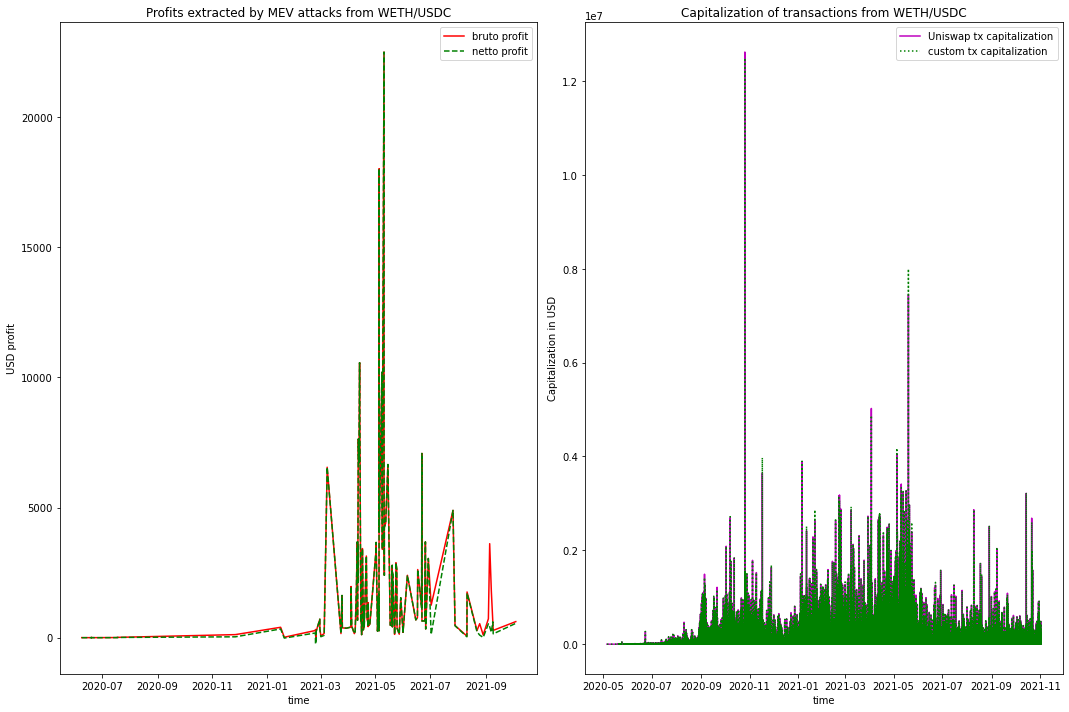

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.plot(grouped_weth_usdc_profits_df['timestamp'], grouped_weth_usdc_profits_df['bruto_total_profit'], label='bruto profit', color='r')
ax1.plot(grouped_weth_usdc_profits_df['timestamp'], grouped_weth_usdc_profits_df['netto_profit'], label='netto profit', color='g', linestyle='--')
ax1.set_xlabel('time')
ax1.set_ylabel('USD profit')
ax1.set_title('Profits extracted by MEV attacks from WETH/USDC')
ax1.legend()

ax2.plot(weth_usdc_swaps_df['timestamp'], weth_usdc_swaps_df['amount_usd'], label="Uniswap tx capitalization", color='m')
ax2.plot(weth_usdc_swaps_df['timestamp'], weth_usdc_swaps_df['total_cap'] / 2, label="custom tx capitalization", color='g',
         linestyle=':')
ax2.set_xlabel('time')
ax2.set_ylabel('Capitalization in USD')
ax2.set_title('Capitalization of transactions from WETH/USDC')
ax2.legend()

plt.tight_layout()
plt.show()

## WBTC/DAI

In [64]:
wbtc_dai_filtered_swaps_df, wbtc_dai_mevs_df = wbtc_dai_sim.extract_filtered_and_mevs_dfs()
wbtc_dai_mevs_df

initial len = 14588, filtered len = 14556
txds = 32
out values = 16


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used
5615,DAI,WBTC,4523.279323,0.083151,4529.538329,2021-04-11 15:09:26,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xceff51756c56ceffca006cd410b03ffc46dd3a58,0x1e2b83c165c15de97028b842f3a7d974eb119514e8fb...,0,10000000
5616,WBTC,DAI,0.078077,4523.279323,4529.538329,2021-04-11 15:09:26,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0x4716e7c7121c0ae1637adecb2bfd1f7b56d9f9eac1cd...,0,10000000
5842,DAI,WBTC,6505.228773,0.116225,6492.614774,2021-04-15 12:46:03,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xceff51756c56ceffca006cd410b03ffc46dd3a58,0xaa2375d2002b37a380aeda8e617f5bc6e6f7e2d4cb43...,0,10000000
5843,WBTC,DAI,0.107027,6505.228773,6492.614774,2021-04-15 12:46:03,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xd63d25592b1e7997ba29c1087414c263a6401c198bca...,0,10000000
10818,WBTC,DAI,2.448900,108073.335496,108297.742050,2021-06-27 01:26:44,0x00000000032962b51589768828ad878876299e14,0xc3d03e4f041fd4cd388c549ee2a29a9e5075882f,0x3fe6174aaa8c5624c31adaf279fb77fb9a49757bb208...,0,2000000
10820,DAI,WBTC,106808.338596,2.448900,107030.118475,2021-06-27 01:26:44,0x00000000032962b51589768828ad878876299e14,0x00000000032962b51589768828ad878876299e14,0xb9efaa9a9cac809ddd24f8b8816ffa5f39f5fb4df880...,0,2000000
12198,WBTC,DAI,6.765949,163521.431029,163387.129530,2021-08-09 00:47:57,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x27a847da96b64ae10854b37c1878c4b3c2aa8be84ccc...,35726447015,3000000
12200,DAI,WBTC,163521.431029,7.702063,163387.129530,2021-08-09 00:47:57,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x86cccda3799a43fbceb4cec6ad8b028f5bf8b3dd,0xa8d343b078a115bb78d4f118120da7ebce02bd25f1d9...,35726447015,3000000
12365,WBTC,DAI,0.125044,5831.149861,5830.043013,2021-08-14 10:31:33,0x66f049111958809841bbe4b81c034da2d953aa0c,0x66f049111958809841bbe4b81c034da2d953aa0c,0x505adfaa1913118b0924f9eda8df0a42afb90472f9d9...,38850039271,300000
12367,DAI,WBTC,5831.149861,0.125787,5830.043013,2021-08-14 10:31:33,0x66f049111958809841bbe4b81c034da2d953aa0c,0x66f049111958809841bbe4b81c034da2d953aa0c,0xf6975925a7236c5f93b273ed78c51b455c3ae72274e8...,38850039271,300000


In [65]:
wbtc_dai_mevs_df = wbtc_dai_sim.calculate_attack_profit(wbtc_dai_mevs_df)
wbtc_dai_mevs_df = wbtc_dai_sim.calculate_attack_profit_by_token(wbtc_dai_mevs_df)

In [66]:
wbtc_dai_mevs_df['date'] = wbtc_dai_mevs_df['timestamp'].dt.strftime("%Y-%m-%d")
wbtc_dai_mevs_df = pd.merge(wbtc_dai_mevs_df, wbtc_price_df, on='date', how='left')
wbtc_dai_mevs_df = pd.merge(wbtc_dai_mevs_df, weth_price_df, on='date', how='left')
wbtc_dai_mevs_df = pd.merge(wbtc_dai_mevs_df, classic_pools_mevs_df, on='txd', how='left')

### Brutto/netto profit calculation

In [67]:
wbtc_dai_mevs_df['bruto_wbtc_to_usdc_profit'] = wbtc_dai_mevs_df['WBTC_profit'] * wbtc_dai_mevs_df['WBTC_price']
wbtc_dai_mevs_df['bruto_total_profit'] = wbtc_dai_mevs_df['bruto_wbtc_to_usdc_profit'] + wbtc_dai_mevs_df['DAI_profit']
wbtc_dai_mevs_df.loc[wbtc_dai_mevs_df['tx_fee'] >= 1, 'tx_fee'] = wbtc_dai_mevs_df['tx_fee'].median()
wbtc_dai_mevs_df.loc[wbtc_dai_mevs_df['tx_fee'] == 0, 'tx_fee'] = wbtc_dai_mevs_df['tx_fee'].median()
wbtc_dai_mevs_df['gas_costs_usd'] = (wbtc_dai_mevs_df['tx_fee'] * wbtc_dai_mevs_df['WETH_price'] *
                                      wbtc_dai_mevs_df['gas_usage_by_tx'])
wbtc_dai_mevs_df['netto_profit'] = wbtc_dai_mevs_df['bruto_total_profit'] - wbtc_dai_mevs_df['gas_costs_usd']
wbtc_dai_mevs_df.dropna(inplace=True)
wbtc_dai_mevs_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,DAI,WBTC,4523.279323,0.083151,4529.538329,2021-04-11 15:09:26,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xceff51756c56ceffca006cd410b03ffc46dd3a58,0x1e2b83c165c15de97028b842f3a7d974eb119514e8fb...,0,...,2145.249496,12219352,2,122852,2150.54,1.108397e-07,304.377963,304.377963,29.211610,275.166353
1,WBTC,DAI,0.078077,4523.279323,4529.538329,2021-04-11 15:09:26,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0x4716e7c7121c0ae1637adecb2bfd1f7b56d9f9eac1cd...,0,...,2145.249496,12219352,0,169427,2150.54,1.108397e-07,304.377963,304.377963,40.286161,264.091801
2,DAI,WBTC,6505.228773,0.116225,6492.614774,2021-04-15 12:46:03,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xceff51756c56ceffca006cd410b03ffc46dd3a58,0xaa2375d2002b37a380aeda8e617f5bc6e6f7e2d4cb43...,0,...,2515.278409,12244728,2,119076,2517.08,1.108397e-07,581.004850,581.004850,33.197529,547.807321
3,WBTC,DAI,0.107027,6505.228773,6492.614774,2021-04-15 12:46:03,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xd63d25592b1e7997ba29c1087414c263a6401c198bca...,0,...,2515.278409,12244728,0,162639,2517.08,1.108397e-07,581.004850,581.004850,45.342579,535.662271
4,WBTC,DAI,2.448900,108073.335496,108297.742050,2021-06-27 01:26:44,0x00000000032962b51589768828ad878876299e14,0xc3d03e4f041fd4cd388c549ee2a29a9e5075882f,0x3fe6174aaa8c5624c31adaf279fb77fb9a49757bb208...,0,...,1978.342839,12713143,2,82495,1983.33,1.108397e-07,0.000000,1264.996900,18.089420,1246.907480
5,DAI,WBTC,106808.338596,2.448900,107030.118475,2021-06-27 01:26:44,0x00000000032962b51589768828ad878876299e14,0x00000000032962b51589768828ad878876299e14,0xb9efaa9a9cac809ddd24f8b8816ffa5f39f5fb4df880...,0,...,1978.342839,12713143,0,100638,1983.33,1.108397e-07,0.000000,1264.996900,22.067799,1242.929101
6,WBTC,DAI,6.765949,163521.431029,163387.129530,2021-08-09 00:47:57,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x27a847da96b64ae10854b37c1878c4b3c2aa8be84ccc...,35726447015,...,3160.660299,12987805,0,145695,3164.94,3.572645e-08,43538.692507,43538.692507,16.451757,43522.240750
7,DAI,WBTC,163521.431029,7.702063,163387.129530,2021-08-09 00:47:57,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x86cccda3799a43fbceb4cec6ad8b028f5bf8b3dd,0xa8d343b078a115bb78d4f118120da7ebce02bd25f1d9...,35726447015,...,3160.660299,12987805,2,134617,3164.94,3.572645e-08,43538.692507,43538.692507,15.200839,43523.491668
8,WBTC,DAI,0.125044,5831.149861,5830.043013,2021-08-14 10:31:33,0x66f049111958809841bbe4b81c034da2d953aa0c,0x66f049111958809841bbe4b81c034da2d953aa0c,0x505adfaa1913118b0924f9eda8df0a42afb90472f9d9...,38850039271,...,3272.467846,13022727,3,90957,3266.71,3.885004e-08,34.866044,34.866044,11.563864,23.302180
9,DAI,WBTC,5831.149861,0.125787,5830.043013,2021-08-14 10:31:33,0x66f049111958809841bbe4b81c034da2d953aa0c,0x66f049111958809841bbe4b81c034da2d953aa0c,0xf6975925a7236c5f93b273ed78c51b455c3ae72274e8...,38850039271,...,3272.467846,13022727,5,89825,3266.71,3.885004e-08,34.866044,34.866044,11.419947,23.446097


In [68]:
print(len(wbtc_dai_mevs_df))
wbtc_dai_mevs_df.drop_duplicates(subset=["timestamp", "amount_in", "txd", "block", "block_position"], inplace=True)
print(len(wbtc_dai_mevs_df))
wbtc_dai_mevs_df

32
32


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_wbtc_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,DAI,WBTC,4523.279323,0.083151,4529.538329,2021-04-11 15:09:26,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xceff51756c56ceffca006cd410b03ffc46dd3a58,0x1e2b83c165c15de97028b842f3a7d974eb119514e8fb...,0,...,2145.249496,12219352,2,122852,2150.54,1.108397e-07,304.377963,304.377963,29.211610,275.166353
1,WBTC,DAI,0.078077,4523.279323,4529.538329,2021-04-11 15:09:26,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0x4716e7c7121c0ae1637adecb2bfd1f7b56d9f9eac1cd...,0,...,2145.249496,12219352,0,169427,2150.54,1.108397e-07,304.377963,304.377963,40.286161,264.091801
2,DAI,WBTC,6505.228773,0.116225,6492.614774,2021-04-15 12:46:03,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xceff51756c56ceffca006cd410b03ffc46dd3a58,0xaa2375d2002b37a380aeda8e617f5bc6e6f7e2d4cb43...,0,...,2515.278409,12244728,2,119076,2517.08,1.108397e-07,581.004850,581.004850,33.197529,547.807321
3,WBTC,DAI,0.107027,6505.228773,6492.614774,2021-04-15 12:46:03,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xf73d5d4962e08c1d572f56e2f3e2728a77507e16,0xd63d25592b1e7997ba29c1087414c263a6401c198bca...,0,...,2515.278409,12244728,0,162639,2517.08,1.108397e-07,581.004850,581.004850,45.342579,535.662271
4,WBTC,DAI,2.448900,108073.335496,108297.742050,2021-06-27 01:26:44,0x00000000032962b51589768828ad878876299e14,0xc3d03e4f041fd4cd388c549ee2a29a9e5075882f,0x3fe6174aaa8c5624c31adaf279fb77fb9a49757bb208...,0,...,1978.342839,12713143,2,82495,1983.33,1.108397e-07,0.000000,1264.996900,18.089420,1246.907480
5,DAI,WBTC,106808.338596,2.448900,107030.118475,2021-06-27 01:26:44,0x00000000032962b51589768828ad878876299e14,0x00000000032962b51589768828ad878876299e14,0xb9efaa9a9cac809ddd24f8b8816ffa5f39f5fb4df880...,0,...,1978.342839,12713143,0,100638,1983.33,1.108397e-07,0.000000,1264.996900,22.067799,1242.929101
6,WBTC,DAI,6.765949,163521.431029,163387.129530,2021-08-09 00:47:57,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x27a847da96b64ae10854b37c1878c4b3c2aa8be84ccc...,35726447015,...,3160.660299,12987805,0,145695,3164.94,3.572645e-08,43538.692507,43538.692507,16.451757,43522.240750
7,DAI,WBTC,163521.431029,7.702063,163387.129530,2021-08-09 00:47:57,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x86cccda3799a43fbceb4cec6ad8b028f5bf8b3dd,0xa8d343b078a115bb78d4f118120da7ebce02bd25f1d9...,35726447015,...,3160.660299,12987805,2,134617,3164.94,3.572645e-08,43538.692507,43538.692507,15.200839,43523.491668
8,WBTC,DAI,0.125044,5831.149861,5830.043013,2021-08-14 10:31:33,0x66f049111958809841bbe4b81c034da2d953aa0c,0x66f049111958809841bbe4b81c034da2d953aa0c,0x505adfaa1913118b0924f9eda8df0a42afb90472f9d9...,38850039271,...,3272.467846,13022727,3,90957,3266.71,3.885004e-08,34.866044,34.866044,11.563864,23.302180
9,DAI,WBTC,5831.149861,0.125787,5830.043013,2021-08-14 10:31:33,0x66f049111958809841bbe4b81c034da2d953aa0c,0x66f049111958809841bbe4b81c034da2d953aa0c,0xf6975925a7236c5f93b273ed78c51b455c3ae72274e8...,38850039271,...,3272.467846,13022727,5,89825,3266.71,3.885004e-08,34.866044,34.866044,11.419947,23.446097


### Bigger sandwiches and profits

In [69]:
wbtc_dai_count_df = wbtc_dai_mevs_df.value_counts(subset=['timestamp'])
wbtc_dai_count_df[wbtc_dai_count_df.values > 2]

Series([], dtype: int64)

In [70]:
grouped_wbtc_dai_profits_df = wbtc_dai_mevs_df.groupby(by=['timestamp']).sum()
grouped_wbtc_dai_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_wbtc_dai_profits_df['block'] = grouped_wbtc_dai_profits_df['block'] / 2
grouped_wbtc_dai_profits_df['bruto_total_profit'] = grouped_wbtc_dai_profits_df['bruto_total_profit']/2
grouped_wbtc_dai_profits_df['netto_profit'] = (grouped_wbtc_dai_profits_df['bruto_total_profit'] -
                                               grouped_wbtc_dai_profits_df['gas_costs_usd'])
grouped_wbtc_dai_profits_df.reset_index(inplace=True)

print(fr"max brutto profit {grouped_wbtc_dai_profits_df['bruto_total_profit'].max()}")
print(fr"min brutto profit {grouped_wbtc_dai_profits_df['bruto_total_profit'].min()}")
print(fr"max netto profit {grouped_wbtc_dai_profits_df['netto_profit'].max()}")
print(fr"min netto profit {grouped_wbtc_dai_profits_df['netto_profit'].min()}")
print(fr"zero bruto profit transactions = {len(wbtc_dai_mevs_df[wbtc_dai_mevs_df['bruto_total_profit'] == 0])}")
print(fr"transactions with losses = {len(wbtc_dai_mevs_df[wbtc_dai_mevs_df['netto_profit'] < 0])}")

max brutto profit 43538.69250716693
min brutto profit 34.86604362366158
max netto profit 43507.03991084643
min netto profit 11.882232921659536
zero bruto profit transactions = 0
transactions with losses = 0


In [71]:
print(fr"sum of paid gas = {sum(wbtc_dai_mevs_df['gas_costs_usd'])}")
print(fr"sum of brutto profits = {sum(wbtc_dai_mevs_df['bruto_total_profit'] / 2)}")
print(fr"sum of netto profits = {sum(wbtc_dai_mevs_df['bruto_total_profit'] / 2) - sum(wbtc_dai_mevs_df['gas_costs_usd'])}")

sum of paid gas = 3076.659100819285
sum of brutto profits = 51516.83200059972
sum of netto profits = 48440.17289978044


### Brutto profit to Uniswap capitalization coefficient

In [72]:
print("brutto attacks profits (" + str(sum(wbtc_dai_mevs_df['bruto_total_profit'] / 2)) +
      ") to WETH/USDC Uniswap capitalization (" + str(wbtc_dai_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(wbtc_dai_mevs_df['bruto_total_profit'] / 2) / wbtc_dai_swaps_df['amount_usd'].sum()))

brutto attacks profits (51516.83200059972) to WETH/USDC Uniswap capitalization (16172704.289918317) coef is equal to 0.003185418534654968


### Brutto profit to custom capitalization coefficient

It is important to perform manual check of the first token value and second token value, considering that it is not possible to set correct token name from the start and requiring manual check of values

In [73]:
wbtc_dai_swaps_df = wbtc_dai_sim.calculate_attack_profit_by_token(wbtc_dai_swaps_df)
wbtc_dai_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used,first_token_value,second_token_value,DAI_profit,WBTC_profit
0,WBTC,DAI,0.000039,0.378642,0.378116,2020-05-20 11:55:36,0xfade503916c1d1253646c36c9961aa47bf14bd2d,0xfade503916c1d1253646c36c9961aa47bf14bd2d,0x337e7bf5b2b4c385597b11dffcf70d0cddac162d4772...,55000000000,1504693,0.378642,0.000039,0.0,0.0
1,WBTC,DAI,0.000017,0.162868,0.161100,2020-05-20 18:34:15,0xfade503916c1d1253646c36c9961aa47bf14bd2d,0xfade503916c1d1253646c36c9961aa47bf14bd2d,0xd36f3e8bc306eb4c2ff894d1a8932c4647913af9d322...,26400000000,1966663,0.162868,0.000017,0.0,0.0
2,WBTC,DAI,0.000256,2.450812,2.382097,2020-05-22 00:32:08,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0xf3eaa95adf2319acf5b57db3f345b4a3f607bba4a833...,25983100000,2572237,2.450812,0.000256,0.0,0.0
3,WBTC,DAI,0.000022,0.208767,0.206079,2020-05-22 10:27:44,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x5c08ee19949610beb1c54ae00eb576564a26a26cb029...,37570500000,784265,0.208767,0.000022,0.0,0.0
4,WBTC,DAI,0.000022,0.208199,0.205794,2020-05-22 10:30:29,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0xb27b3c99425963ec06978be76fb6c47ce34eaf3fbb16...,37411000000,757265,0.208199,0.000022,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14583,WBTC,DAI,0.045069,1631.162353,1633.458991,2022-01-25 11:11:27,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x108cb2a6e3e996a0780c015b7b565ed731daf294,0x2dbfa0cac1c0d2864694d7eea0c7b050ecefa7251386...,69486615871,139050,1631.162353,0.045069,0.0,0.0
14584,DAI,WBTC,943.324503,0.025976,940.942854,2022-01-25 11:25:19,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbb2b8038a1640196fbe3e38816f3e67cba72d940,0xebd94779d32a2f9e46e546d0a3831a7a584f6562b64a...,69714077947,492550,943.324503,0.025976,0.0,0.0
14585,DAI,WBTC,1526.991067,0.041659,1528.224535,2022-01-25 16:39:48,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xbb2b8038a1640196fbe3e38816f3e67cba72d940,0x28815f7298dd0b8dd5be1e6fe30ce70955ef98a76a08...,150000000000,249436,1526.991067,0.041659,0.0,0.0
14586,DAI,WBTC,1221.280946,0.032977,1221.767439,2022-01-25 17:12:37,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x9008d19f58aabd9ed0d60971565aa8510560ab41,0xacf568740475398473dec31388f010619a52358fee62...,163710763064,353868,1221.280946,0.032977,0.0,0.0


In [74]:
wbtc_dai_swaps_df['date'] = wbtc_dai_swaps_df['timestamp'].dt.strftime("%Y-%m-%d")
wbtc_dai_swaps_df = pd.merge(wbtc_dai_swaps_df, wbtc_price_df, on='date', how='left')
wbtc_dai_swaps_df['cap_wbtc_to_usdc'] = wbtc_dai_swaps_df['second_token_value'] * wbtc_dai_swaps_df['WBTC_price']
wbtc_dai_swaps_df['total_cap'] = wbtc_dai_swaps_df['cap_wbtc_to_usdc'] + wbtc_dai_swaps_df['first_token_value']

In [75]:
print("brutto attacks profits (" + str(sum(wbtc_dai_mevs_df['bruto_total_profit'] / 2)) +
      ") to WBTC/DAI custom capitalization (" + str(wbtc_dai_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(wbtc_dai_mevs_df['bruto_total_profit'] / 2) / wbtc_dai_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (51516.83200059972) to WBTC/DAI custom capitalization (16329722.445156455) coef is equal to 0.0007886972998717453


### Netto profit to Uniswap capitalization coefficient

In [76]:
print("netto attacks profits (" + str(sum(wbtc_dai_mevs_df['netto_profit'] / 2)) +
      ") to WBTC/DAI Uniswap capitalization (" + str(wbtc_dai_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(wbtc_dai_mevs_df['netto_profit'] / 2) / wbtc_dai_swaps_df['amount_usd'].sum()))

netto attacks profits (49978.502450190084) to WBTC/DAI Uniswap capitalization (16172704.289918317) coef is equal to 0.0030902996526898418


### Netto profit to custom capitalization coefficient

In [77]:
print("netto attacks profits (" + str(sum(wbtc_dai_mevs_df['netto_profit'] / 2)) +
      ") to WBTC/DAI custom capitalization (" + str(wbtc_dai_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(wbtc_dai_mevs_df['netto_profit'] / 2) / wbtc_dai_swaps_df['total_cap'].sum() / 2))

netto attacks profits (49978.502450190084) to WBTC/DAI custom capitalization (16329722.445156455) coef is equal to 0.0007651462328591838


### MEV transactions frequency to standard transactions

MEVs frequency is extremely small and can be seen that there is almost no MEV activity registered in such a big pool

In [78]:
print("WBTC/DAI pool contains " + str(len(wbtc_dai_mevs_df) / 2) + " MEV attacks (or " +
      str(len(wbtc_dai_mevs_df)) + " MEV transactions) out of " + str(len(wbtc_dai_swaps_df)) +
      " total transactions." +
      "\nCoefficient of MEV attacks = " + str((len(wbtc_dai_mevs_df) / 2) / len(wbtc_dai_swaps_df)) +
      "; coefficient of MEV transactions = " + str(len(wbtc_dai_mevs_df) / len(wbtc_dai_swaps_df)) +
      "\nCoef of MEV attacks cap = " + str(wbtc_dai_mevs_df['amount_usd'].sum() / wbtc_dai_swaps_df['amount_usd'].sum()))

WBTC/DAI pool contains 16.0 MEV attacks (or 32 MEV transactions) out of 14588 total transactions.
Coefficient of MEV attacks = 0.0010967918837400603; coefficient of MEV transactions = 0.0021935837674801205
Coef of MEV attacks cap = 0.10259791815319497


### Distributions of profits and capitalizations

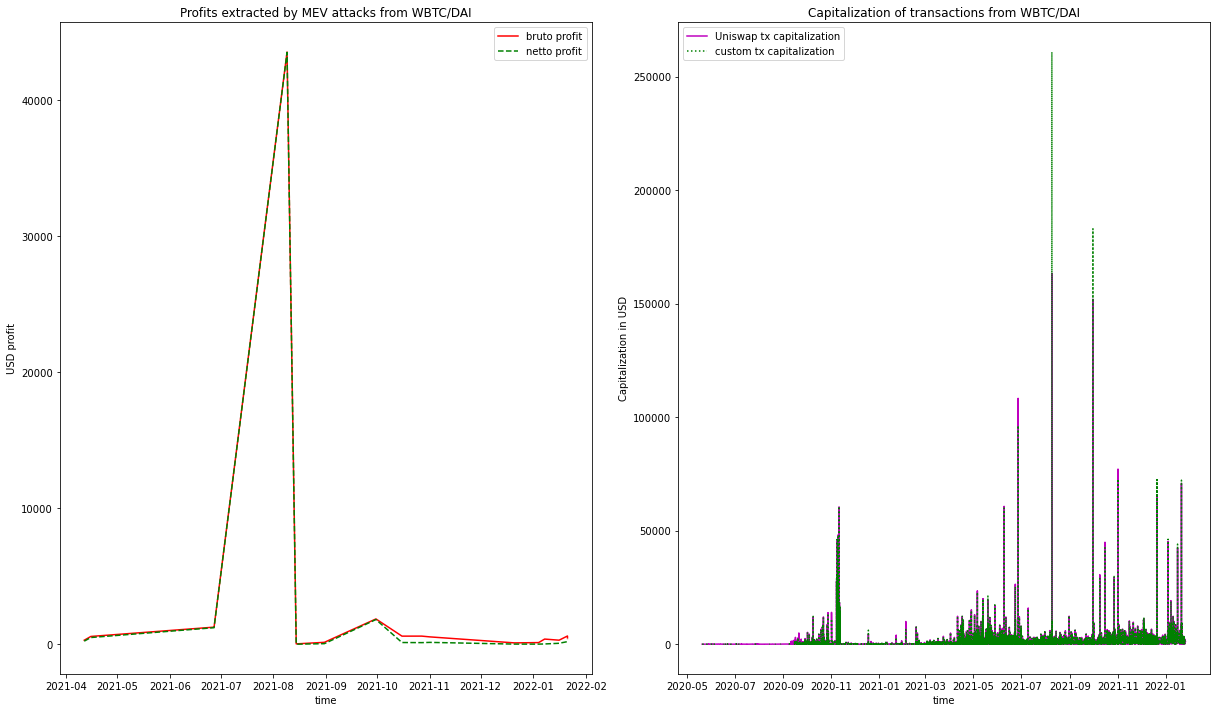

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 10))
ax1.plot(grouped_wbtc_dai_profits_df['timestamp'], grouped_wbtc_dai_profits_df['bruto_total_profit'], label='bruto profit', color='r')
ax1.plot(grouped_wbtc_dai_profits_df['timestamp'], grouped_wbtc_dai_profits_df['netto_profit'], label='netto profit', color='g', linestyle='--')
ax1.set_xlabel('time')
ax1.set_ylabel('USD profit')
ax1.set_title('Profits extracted by MEV attacks from WBTC/DAI')
ax1.legend()

ax2.plot(wbtc_dai_swaps_df['timestamp'], wbtc_dai_swaps_df['amount_usd'], label="Uniswap tx capitalization", color='m')
ax2.plot(wbtc_dai_swaps_df['timestamp'], wbtc_dai_swaps_df['total_cap'] / 2, label="custom tx capitalization", color='g',
         linestyle=':')
ax2.set_xlabel('time')
ax2.set_ylabel('Capitalization in USD')
ax2.set_title('Capitalization of transactions from WBTC/DAI')
ax2.legend()

plt.tight_layout()
plt.show()

## FEI/WETH

In [80]:
fei_weth_filtered_swaps_df, fei_weth_mevs_df = fei_weth_sim.extract_filtered_and_mevs_dfs()
fei_weth_mevs_df

initial len = 61369, filtered len = 61287
txds = 82
out values = 41


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used
2843,WETH,FEI,100.000000,202015.483541,200571.731376,2021-04-07 23:12:58,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x617833310ff234328c56967e6fa51ee516fde425b667...,1000000000,200000
2848,FEI,WETH,202015.483541,100.404006,201382.052237,2021-04-07 23:12:58,0xd78a3280085ee846196cb5fab7d510b279486d44,0xd78a3280085ee846196cb5fab7d510b279486d44,0xcf397984b34c481b286c92c535fe3c40933519ed3324...,1000000000,200000
3134,FEI,WETH,239259.262227,100.206869,199309.218215,2021-04-07 23:38:16,0xd78a3280085ee846196cb5fab7d510b279486d44,0xd78a3280085ee846196cb5fab7d510b279486d44,0x635c765e8fc4d4203df84e33aa3622704ba2924923a8...,1000000000,200000
3136,WETH,FEI,100.000000,239259.262227,198897.760117,2021-04-07 23:38:16,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x6bc7d189bde38bd7f3884e43595f0bcf9bff68e936fb...,1000000000,200000
5212,WETH,FEI,116.610000,318272.600375,250424.561140,2021-04-12 12:43:18,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x369cd93865ebed43feeee491cbce0c072c2ed2062937...,1000000000,200000
...,...,...,...,...,...,...,...,...,...,...,...
48884,WETH,FEI,82.906192,383099.326306,385753.049929,2021-11-13 21:52:52,0x000000000035b5e5ad9019092c665357240f594e,0x000000000035b5e5ad9019092c665357240f594e,0xbc00fc958132c08d808c0d4be162b34e986b3b885907...,106613216296,105018
56397,WETH,FEI,116.577547,394863.994633,390241.752749,2022-01-06 10:44:42,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,0x8dd415d16427b6fd074d38c6c932a5bb47aeb1287b3b...,2387690069881,250193
56398,FEI,WETH,392832.970657,116.577547,390241.752749,2022-01-06 10:44:42,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x97a551bcf7b00b48996ea8aa0156cde2854801087a21...,81900359698,2000000
56550,WETH,FEI,196.390338,652788.054737,635235.381568,2022-01-07 03:57:45,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,0x6a33c22baee6a5b175cee0ab98cf35f9c67e0e733f0f...,8236155502370,250193


In [81]:
fei_weth_mevs_df = fei_weth_sim.calculate_attack_profit(fei_weth_mevs_df)
fei_weth_mevs_df = fei_weth_sim.calculate_attack_profit_by_token(fei_weth_mevs_df)

In [82]:
fei_weth_mevs_df['date'] = fei_weth_mevs_df['timestamp'].dt.strftime("%Y-%m-%d")
fei_weth_mevs_df = pd.merge(fei_weth_mevs_df, weth_price_df, on='date', how='left')
fei_weth_mevs_df = pd.merge(fei_weth_mevs_df, classic_pools_mevs_df, on='txd', how='left')

### Brutto/netto profit calculation

In [83]:
fei_weth_mevs_df['bruto_weth_to_usdc_profit'] = fei_weth_mevs_df['WETH_profit'] * fei_weth_mevs_df['WETH_price']
fei_weth_mevs_df['bruto_total_profit'] = fei_weth_mevs_df['bruto_weth_to_usdc_profit'] + fei_weth_mevs_df['FEI_profit']
fei_weth_mevs_df.loc[fei_weth_mevs_df['tx_fee'] >= 1, 'tx_fee'] = fei_weth_mevs_df['tx_fee'].median()
fei_weth_mevs_df.loc[fei_weth_mevs_df['tx_fee'] == 0, 'tx_fee'] = fei_weth_mevs_df['tx_fee'].median()
fei_weth_mevs_df['gas_costs_usd'] = (fei_weth_mevs_df['tx_fee'] * fei_weth_mevs_df['WETH_price'] *
                                      fei_weth_mevs_df['gas_usage_by_tx'])
fei_weth_mevs_df['netto_profit'] = fei_weth_mevs_df['bruto_total_profit'] - fei_weth_mevs_df['gas_costs_usd']
fei_weth_mevs_df.dropna(inplace=True)
fei_weth_mevs_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_weth_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,WETH,FEI,100.000000,202015.483541,200571.731376,2021-04-07 23:12:58,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x617833310ff234328c56967e6fa51ee516fde425b667...,1000000000,...,1966.292699,12195610,3,160555,1964.18,1.000000e-09,794.393099,794.393099,0.315698,794.077400
1,FEI,WETH,202015.483541,100.404006,201382.052237,2021-04-07 23:12:58,0xd78a3280085ee846196cb5fab7d510b279486d44,0xd78a3280085ee846196cb5fab7d510b279486d44,0xcf397984b34c481b286c92c535fe3c40933519ed3324...,1000000000,...,1966.292699,12195610,6,137153,1964.18,1.000000e-09,794.393099,794.393099,0.269683,794.123416
2,FEI,WETH,239259.262227,100.206869,199309.218215,2021-04-07 23:38:16,0xd78a3280085ee846196cb5fab7d510b279486d44,0xd78a3280085ee846196cb5fab7d510b279486d44,0x635c765e8fc4d4203df84e33aa3622704ba2924923a8...,1000000000,...,1966.292699,12195735,6,137153,1964.18,1.000000e-09,406.765291,406.765291,0.269683,406.495609
3,WETH,FEI,100.000000,239259.262227,198897.760117,2021-04-07 23:38:16,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x6bc7d189bde38bd7f3884e43595f0bcf9bff68e936fb...,1000000000,...,1966.292699,12195735,4,160555,1964.18,1.000000e-09,406.765291,406.765291,0.315698,406.449593
4,WETH,FEI,116.610000,318272.600375,250424.561140,2021-04-12 12:43:18,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x369cd93865ebed43feeee491cbce0c072c2ed2062937...,1000000000,...,2142.029148,12225308,0,173800,2137.79,1.000000e-09,732.303958,732.303958,0.372285,731.931673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,WETH,FEI,82.906192,383099.326306,385753.049929,2021-11-13 21:52:52,0x000000000035b5e5ad9019092c665357240f594e,0x000000000035b5e5ad9019092c665357240f594e,0xbc00fc958132c08d808c0d4be162b34e986b3b885907...,106613216296,...,4644.623770,13610158,0,95018,4645.64,1.066132e-07,3982.358975,3982.358975,47.050850,3935.308125
78,WETH,FEI,116.577547,394863.994633,390241.752749,2022-01-06 10:44:42,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,0x8dd415d16427b6fd074d38c6c932a5bb47aeb1287b3b...,2387690069881,...,3414.183840,13951372,2,142963,3406.48,2.387690e-06,0.000000,2031.023976,1165.436213,865.587762
79,FEI,WETH,392832.970657,116.577547,390241.752749,2022-01-06 10:44:42,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x97a551bcf7b00b48996ea8aa0156cde2854801087a21...,81900359698,...,3414.183840,13951372,0,156710,3406.48,8.190036e-08,0.000000,2031.023976,43.819702,1987.204274
80,WETH,FEI,196.390338,652788.054737,635235.381568,2022-01-07 03:57:45,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,0x6a33c22baee6a5b175cee0ab98cf35f9c67e0e733f0f...,8236155502370,...,3187.113198,13956019,2,142963,3196.47,8.236156e-06,0.000000,6062.103684,3752.715832,2309.387851


In [84]:
print(len(fei_weth_mevs_df))
fei_weth_mevs_df.drop_duplicates(subset=["timestamp", "amount_in", "txd", "block", "block_position"], inplace=True)
print(len(fei_weth_mevs_df))
fei_weth_mevs_df

82
82


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_weth_to_usdc_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,WETH,FEI,100.000000,202015.483541,200571.731376,2021-04-07 23:12:58,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x617833310ff234328c56967e6fa51ee516fde425b667...,1000000000,...,1966.292699,12195610,3,160555,1964.18,1.000000e-09,794.393099,794.393099,0.315698,794.077400
1,FEI,WETH,202015.483541,100.404006,201382.052237,2021-04-07 23:12:58,0xd78a3280085ee846196cb5fab7d510b279486d44,0xd78a3280085ee846196cb5fab7d510b279486d44,0xcf397984b34c481b286c92c535fe3c40933519ed3324...,1000000000,...,1966.292699,12195610,6,137153,1964.18,1.000000e-09,794.393099,794.393099,0.269683,794.123416
2,FEI,WETH,239259.262227,100.206869,199309.218215,2021-04-07 23:38:16,0xd78a3280085ee846196cb5fab7d510b279486d44,0xd78a3280085ee846196cb5fab7d510b279486d44,0x635c765e8fc4d4203df84e33aa3622704ba2924923a8...,1000000000,...,1966.292699,12195735,6,137153,1964.18,1.000000e-09,406.765291,406.765291,0.269683,406.495609
3,WETH,FEI,100.000000,239259.262227,198897.760117,2021-04-07 23:38:16,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x6bc7d189bde38bd7f3884e43595f0bcf9bff68e936fb...,1000000000,...,1966.292699,12195735,4,160555,1964.18,1.000000e-09,406.765291,406.765291,0.315698,406.449593
4,WETH,FEI,116.610000,318272.600375,250424.561140,2021-04-12 12:43:18,0xd78a3280085ee846196cb5fab7d510b279486d44,0xf6da21e95d74767009accb145b96897ac3630bad,0x369cd93865ebed43feeee491cbce0c072c2ed2062937...,1000000000,...,2142.029148,12225308,0,173800,2137.79,1.000000e-09,732.303958,732.303958,0.372285,731.931673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,WETH,FEI,82.906192,383099.326306,385753.049929,2021-11-13 21:52:52,0x000000000035b5e5ad9019092c665357240f594e,0x000000000035b5e5ad9019092c665357240f594e,0xbc00fc958132c08d808c0d4be162b34e986b3b885907...,106613216296,...,4644.623770,13610158,0,95018,4645.64,1.066132e-07,3982.358975,3982.358975,47.050850,3935.308125
78,WETH,FEI,116.577547,394863.994633,390241.752749,2022-01-06 10:44:42,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,0x8dd415d16427b6fd074d38c6c932a5bb47aeb1287b3b...,2387690069881,...,3414.183840,13951372,2,142963,3406.48,2.387690e-06,0.000000,2031.023976,1165.436213,865.587762
79,FEI,WETH,392832.970657,116.577547,390241.752749,2022-01-06 10:44:42,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x97a551bcf7b00b48996ea8aa0156cde2854801087a21...,81900359698,...,3414.183840,13951372,0,156710,3406.48,8.190036e-08,0.000000,2031.023976,43.819702,1987.204274
80,WETH,FEI,196.390338,652788.054737,635235.381568,2022-01-07 03:57:45,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xbb2e5c2ff298fd96e166f90c8abacaf714df14f8,0x6a33c22baee6a5b175cee0ab98cf35f9c67e0e733f0f...,8236155502370,...,3187.113198,13956019,2,142963,3196.47,8.236156e-06,0.000000,6062.103684,3752.715832,2309.387851


### Bigger sandwiches and profits

In [85]:
fei_weth_count_df = fei_weth_mevs_df.value_counts(subset=['timestamp'])
fei_weth_count_df[fei_weth_count_df.values > 2]

Series([], dtype: int64)

In [86]:
grouped_fei_weth_profits_df = fei_weth_mevs_df.groupby(by=['timestamp']).sum()
grouped_fei_weth_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_fei_weth_profits_df['block'] = grouped_fei_weth_profits_df['block'] / 2
grouped_fei_weth_profits_df['bruto_total_profit'] = grouped_fei_weth_profits_df['bruto_total_profit']/2
grouped_fei_weth_profits_df['netto_profit'] = (grouped_fei_weth_profits_df['bruto_total_profit'] -
                                               grouped_fei_weth_profits_df['gas_costs_usd'])
grouped_fei_weth_profits_df.reset_index(inplace=True)

print(fr"max brutto profit {grouped_fei_weth_profits_df['bruto_total_profit'].max()}")
print(fr"min brutto profit {grouped_fei_weth_profits_df['bruto_total_profit'].min()}")
print(fr"max netto profit {grouped_fei_weth_profits_df['netto_profit'].max()}")
print(fr"min netto profit {grouped_fei_weth_profits_df['netto_profit'].min()}")
print(fr"zero bruto profit transactions = {len(fei_weth_mevs_df[fei_weth_mevs_df['bruto_total_profit'] == 0])}")
print(fr"transactions with losses = {len(fei_weth_mevs_df[fei_weth_mevs_df['netto_profit'] < 0])}")

max brutto profit 8535.902932896952
min brutto profit 67.68799032483486
max netto profit 8534.806331420927
min netto profit 21.29403931420427
zero bruto profit transactions = 0
transactions with losses = 0


In [87]:
print(fr"sum of paid gas = {sum(fei_weth_mevs_df['gas_costs_usd'])}")
print(fr"sum of brutto profits = {sum(fei_weth_mevs_df['bruto_total_profit'] / 2)}")
print(fr"sum of netto profits = {sum(fei_weth_mevs_df['bruto_total_profit'] / 2) - sum(fei_weth_mevs_df['gas_costs_usd'])}")

sum of paid gas = 13582.57773146535
sum of brutto profits = 91539.21555558126
sum of netto profits = 77956.63782411591


### Brutto profit to Uniswap capitalization coefficient

In [88]:
print("brutto attacks profits (" + str(sum(fei_weth_mevs_df['bruto_total_profit'] / 2)) +
      ") to FEI/WETH Uniswap capitalization (" + str(fei_weth_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(fei_weth_mevs_df['bruto_total_profit'] / 2) / fei_weth_swaps_df['amount_usd'].sum()))

brutto attacks profits (91539.21555558126) to FEI/WETH Uniswap capitalization (7980750883.061473) coef is equal to 1.14700003667407e-05


### Brutto profit to custom capitalization coefficient

It is important to perform manual check of the first token value and second token value, considering that it is not possible to set correct token name from the start and requiring manual check of values

In [89]:
fei_weth_swaps_df = fei_weth_sim.calculate_attack_profit_by_token(fei_weth_swaps_df)
fei_weth_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used,first_token_value,second_token_value,FEI_profit,WETH_profit
0,FEI,WETH,1.945271e+06,928.783242,1.916057e+06,2021-04-03 19:00:36,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x3347f819f2bf7e7c54f59b97fecb84399ff479f93d2f...,3002020000000,500000,1.945271e+06,928.783242,6.628642e+06,3195.320520
1,FEI,WETH,9.518713e+05,455.470626,9.396247e+05,2021-04-03 19:00:36,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x59e7772688fe9966abfeba79408ca9aedbf316bf4761...,3002010000000,500000,9.518713e+05,455.470626,6.628642e+06,3195.320520
2,FEI,WETH,7.580513e+06,3650.791147,7.531493e+06,2021-04-03 19:00:36,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2ebd449e7b10b20135b6c1134b9e40c84f9fffde,0x641b95d1f76a4a9e0101df94aab04aee23f95bca349f...,10001000000001,1000000,7.580513e+06,3650.791147,6.628642e+06,3195.320520
3,FEI,WETH,9.905835e+05,471.915956,9.734749e+05,2021-04-03 19:01:19,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x2fd4a218b8733ebe9e3ebf950e3aae1e0981b3b336de...,5000000000000,315784,9.905835e+05,471.915956,9.901659e+05,471.715956
4,WETH,FEI,2.000000e-01,417.609981,4.130432e+02,2021-04-03 19:01:19,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc3ec7b35180768cf73d2f5ff9ec82485106d5d7c,0x3dd3e1b61fbe1dcfc3c5a60ceed774b914704df32ba7...,196900000233,312275,4.176100e+02,0.200000,9.901659e+05,471.715956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61364,WETH,FEI,1.250000e+00,3101.054389,3.103672e+03,2022-01-26 08:42:51,0x5f62593c70069abb35dfe2b63db969e8906609d6,0x9241943c29eb0b1fc0f8e5b464fbc14915da9a57,0xa0533988e051f90557f1a1153ebe4c1538ccda8c7dd9...,81398716000,1044340,3.101054e+03,1.250000,0.000000e+00,0.000000
61365,FEI,WETH,3.143161e+04,12.584879,3.124559e+04,2022-01-26 08:44:06,0x2057cfb9fd11837d61b294d514c5bd03e5e7189a,0x2057cfb9fd11837d61b294d514c5bd03e5e7189a,0xc58a934d449865f9e951871e3f8515b027299f6fd348...,88447887546,1895934,3.143161e+04,12.584879,0.000000e+00,0.000000
61366,WETH,FEI,7.796160e+00,19360.679596,1.937078e+04,2022-01-26 08:49:08,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0xef274edbdb0e346f2262b7a8df1ebdb9eb01ef309acb...,78278445132,838211,1.936068e+04,7.796160,0.000000e+00,0.000000
61367,WETH,FEI,9.991968e+00,24786.067156,2.482588e+04,2022-01-26 08:49:12,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,0xebf50cdf250cfa1ae316c5acdb8df1be3b3ed6337361...,197362846827,713567,2.478607e+04,9.991968,0.000000e+00,0.000000


In [90]:
fei_weth_swaps_df['date'] = fei_weth_swaps_df['timestamp'].dt.strftime("%Y-%m-%d")
fei_weth_swaps_df = pd.merge(fei_weth_swaps_df, weth_price_df, on='date', how='left')
fei_weth_swaps_df['cap_weth_to_usdc'] = fei_weth_swaps_df['second_token_value'] * fei_weth_swaps_df['WETH_price']
fei_weth_swaps_df['total_cap'] = fei_weth_swaps_df['cap_weth_to_usdc'] + fei_weth_swaps_df['first_token_value']

In [91]:
print("brutto attacks profits (" + str(sum(fei_weth_mevs_df['bruto_total_profit'] / 2)) +
      ") to FEI/WETH custom capitalization (" + str(fei_weth_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(fei_weth_mevs_df['bruto_total_profit'] / 2) / fei_weth_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (91539.21555558126) to FEI/WETH custom capitalization (8141523117.874255) coef is equal to 2.8108750116612724e-06


### Netto profit to Uniswap capitalization coefficient

In [92]:
print("netto attacks profits (" + str(sum(fei_weth_mevs_df['netto_profit'] / 2)) +
      ") to FEI/WETH Uniswap capitalization (" + str(fei_weth_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(fei_weth_mevs_df['netto_profit'] / 2) / fei_weth_swaps_df['amount_usd'].sum()))

netto attacks profits (84747.92668984857) to FEI/WETH Uniswap capitalization (7980750883.061473) coef is equal to 1.0619041733243358e-05


### Netto profit to custom capitalization coefficient

In [93]:
print("netto attacks profits (" + str(sum(fei_weth_mevs_df['netto_profit'] / 2)) +
      ") to FEI/WETH custom capitalization (" + str(fei_weth_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(fei_weth_mevs_df['netto_profit'] / 2) / fei_weth_swaps_df['total_cap'].sum() / 2))

netto attacks profits (84747.92668984857) to FEI/WETH custom capitalization (8141523117.874255) coef is equal to 2.602336364549198e-06


### MEV transactions frequency to standard transactions

MEVs frequency is extremely small and can be seen that there is almost no MEV activity registered in such a big pool

In [94]:
print("FEI/WETH pool contains " + str(len(fei_weth_mevs_df) / 2) + " MEV attacks (or " +
      str(len(fei_weth_mevs_df)) + " MEV transactions) out of " + str(len(fei_weth_swaps_df)) +
      " total transactions." +
      "\nCoefficient of MEV attacks = " + str((len(fei_weth_mevs_df) / 2) / len(fei_weth_swaps_df)) +
      "; coefficient of MEV transactions = " + str(len(fei_weth_mevs_df) / len(fei_weth_swaps_df)) +
      "\nCoef of MEV attacks cap = " + str(fei_weth_mevs_df['amount_usd'].sum() / fei_weth_swaps_df['amount_usd'].sum()))

FEI/WETH pool contains 41.0 MEV attacks (or 82 MEV transactions) out of 61369 total transactions.
Coefficient of MEV attacks = 0.0006680897521549968; coefficient of MEV transactions = 0.0013361795043099936
Coef of MEV attacks cap = 0.003667129275273949


### Distributions of profits and capitalizations

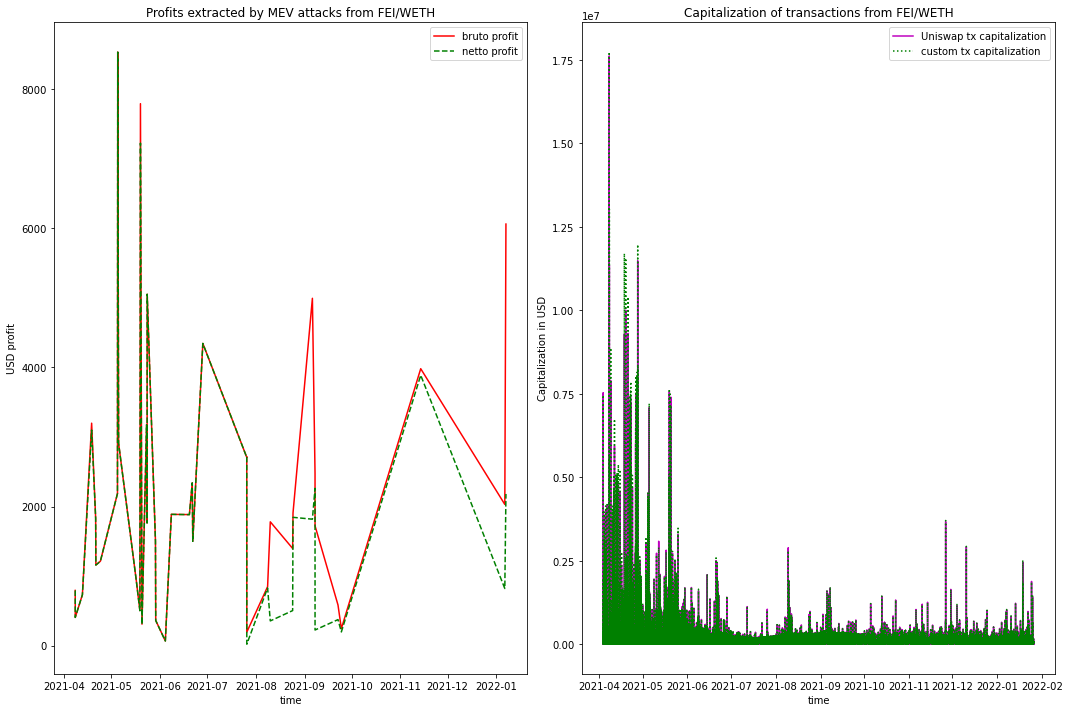

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.plot(grouped_fei_weth_profits_df['timestamp'], grouped_fei_weth_profits_df['bruto_total_profit'], label='bruto profit', color='r')
ax1.plot(grouped_fei_weth_profits_df['timestamp'], grouped_fei_weth_profits_df['netto_profit'], label='netto profit', color='g', linestyle='--')
ax1.set_xlabel('time')
ax1.set_ylabel('USD profit')
ax1.set_title('Profits extracted by MEV attacks from FEI/WETH')
ax1.legend()

ax2.plot(fei_weth_swaps_df['timestamp'], fei_weth_swaps_df['amount_usd'], label="Uniswap tx capitalization", color='m')
ax2.plot(fei_weth_swaps_df['timestamp'], fei_weth_swaps_df['total_cap'] / 2, label="custom tx capitalization", color='g',
         linestyle=':')
ax2.set_xlabel('time')
ax2.set_ylabel('Capitalization in USD')
ax2.set_title('Capitalization of transactions from FEI/WETH')
ax2.legend()

plt.tight_layout()
plt.show()

## HKMT/USDT

In [96]:
hkmt_usdt_filtered_swaps_df, hkmt_usdt_mevs_df = hkmt_usdt_sim.extract_filtered_and_mevs_dfs()
hkmt_usdt_mevs_df

initial len = 429, filtered len = 427
txds = 2
out values = 1


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used
426,USDT,HKMT,122981.406976,983689.039976,122823.392267,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x6eb7c947848fa63ebfe5ffa539a166afdb4d8043600a...,86561223573,2000000
428,HKMT,USDT,983689.039976,123239.317760,123080.971670,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xcd6b5cc70a049e39ffa37fa65428a09cfeae85be144e...,943775881669,162659


In [97]:
hkmt_usdt_mevs_df = hkmt_usdt_sim.calculate_attack_profit(hkmt_usdt_mevs_df)
hkmt_usdt_mevs_df = hkmt_usdt_sim.calculate_attack_profit_by_token(hkmt_usdt_mevs_df)

In [98]:
hkmt_price_df = hkmt_usdt_sim.get_daily_token_price(first_to_second=False, token_name='HKMT')
hkmt_price_df['date'] = hkmt_price_df['date'].dt.strftime("%Y-%m-%d")

In [99]:
hkmt_usdt_mevs_df['date'] = hkmt_usdt_mevs_df['timestamp'].dt.strftime("%Y-%m-%d")
hkmt_usdt_mevs_df = pd.merge(hkmt_usdt_mevs_df, hkmt_price_df, on='date', how='left')
hkmt_usdt_mevs_df = pd.merge(hkmt_usdt_mevs_df, weth_price_df, on='date', how='left')
hkmt_usdt_mevs_df = pd.merge(hkmt_usdt_mevs_df, classic_pools_mevs_df, on='txd', how='left')

### Brutto/netto profit calculation

In [100]:
hkmt_usdt_mevs_df['bruto_hkmt_to_usdt_profit'] = hkmt_usdt_mevs_df['HKMT_profit'] * hkmt_usdt_mevs_df['HKMT_price']
hkmt_usdt_mevs_df['bruto_total_profit'] = hkmt_usdt_mevs_df['bruto_hkmt_to_usdt_profit'] + hkmt_usdt_mevs_df['USDT_profit']
hkmt_usdt_mevs_df.loc[hkmt_usdt_mevs_df['tx_fee'] >= 1, 'tx_fee'] = hkmt_usdt_mevs_df['tx_fee'].median()
hkmt_usdt_mevs_df.loc[hkmt_usdt_mevs_df['tx_fee'] == 0, 'tx_fee'] = hkmt_usdt_mevs_df['tx_fee'].median()
hkmt_usdt_mevs_df['gas_costs_usd'] = (hkmt_usdt_mevs_df['tx_fee'] * hkmt_usdt_mevs_df['WETH_price'] *
                                      hkmt_usdt_mevs_df['gas_usage_by_tx'])
hkmt_usdt_mevs_df['netto_profit'] = hkmt_usdt_mevs_df['bruto_total_profit'] - hkmt_usdt_mevs_df['gas_costs_usd']
hkmt_usdt_mevs_df.dropna(inplace=True)
hkmt_usdt_mevs_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_hkmt_to_usdt_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,USDT,HKMT,122981.406976,983689.039976,122823.392267,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x6eb7c947848fa63ebfe5ffa539a166afdb4d8043600a...,86561223573,...,2465.400061,14079833,0,102974,2464.13,8.656122e-08,0.0,257.910784,21.975480,235.935304
1,HKMT,USDT,983689.039976,123239.317760,123080.971670,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xcd6b5cc70a049e39ffa37fa65428a09cfeae85be144e...,943775881669,...,2465.400061,14079833,2,92944,2464.13,9.437759e-07,0.0,257.910784,216.260716,41.650068


In [101]:
print(len(hkmt_usdt_mevs_df))
hkmt_usdt_mevs_df.drop_duplicates(subset=["timestamp", "amount_in", "txd", "block", "block_position"], inplace=True)
print(len(hkmt_usdt_mevs_df))
hkmt_usdt_mevs_df

2
2


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_hkmt_to_usdt_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,USDT,HKMT,122981.406976,983689.039976,122823.392267,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x6eb7c947848fa63ebfe5ffa539a166afdb4d8043600a...,86561223573,...,2465.400061,14079833,0,102974,2464.13,8.656122e-08,0.0,257.910784,21.975480,235.935304
1,HKMT,USDT,983689.039976,123239.317760,123080.971670,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xcd6b5cc70a049e39ffa37fa65428a09cfeae85be144e...,943775881669,...,2465.400061,14079833,2,92944,2464.13,9.437759e-07,0.0,257.910784,216.260716,41.650068


### Bigger sandwiches and profits

In [102]:
hkmt_usdt_count_df = hkmt_usdt_mevs_df.value_counts(subset=['timestamp'])
hkmt_usdt_count_df[hkmt_usdt_count_df.values > 2]

Series([], dtype: int64)

In [103]:
grouped_hkmt_usdt_profits_df = hkmt_usdt_mevs_df.groupby(by=['timestamp']).sum()
grouped_hkmt_usdt_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_hkmt_usdt_profits_df['block'] = grouped_hkmt_usdt_profits_df['block'] / 2
grouped_hkmt_usdt_profits_df['bruto_total_profit'] = grouped_hkmt_usdt_profits_df['bruto_total_profit']/2
grouped_hkmt_usdt_profits_df['netto_profit'] = (grouped_hkmt_usdt_profits_df['bruto_total_profit'] -
                                                grouped_hkmt_usdt_profits_df['gas_costs_usd'])
grouped_hkmt_usdt_profits_df.reset_index(inplace=True)

print(fr"max brutto profit {grouped_hkmt_usdt_profits_df['bruto_total_profit'].max()}")
print(fr"min brutto profit {grouped_hkmt_usdt_profits_df['bruto_total_profit'].min()}")
print(fr"max netto profit {grouped_hkmt_usdt_profits_df['netto_profit'].max()}")
print(fr"min netto profit {grouped_hkmt_usdt_profits_df['netto_profit'].min()}")
print(fr"zero bruto profit transactions = {len(hkmt_usdt_mevs_df[hkmt_usdt_mevs_df['bruto_total_profit'] == 0])}")
print(fr"transactions with losses = {len(hkmt_usdt_mevs_df[hkmt_usdt_mevs_df['netto_profit'] < 0])}")

max brutto profit 257.91078400000697
min brutto profit 257.91078400000697
max netto profit 19.67458809963736
min netto profit 19.67458809963736
zero bruto profit transactions = 0
transactions with losses = 0


In [104]:
print(fr"sum of paid gas = {sum(hkmt_usdt_mevs_df['gas_costs_usd'])}")
print(fr"sum of brutto profits = {sum(hkmt_usdt_mevs_df['bruto_total_profit'] / 2)}")
print(fr"sum of netto profits = {sum(hkmt_usdt_mevs_df['bruto_total_profit'] / 2) - sum(hkmt_usdt_mevs_df['gas_costs_usd'])}")

sum of paid gas = 238.2361959003696
sum of brutto profits = 257.91078400000697
sum of netto profits = 19.67458809963736


### Brutto profit to Uniswap capitalization coefficient

In [105]:
print("brutto attacks profits (" + str(sum(hkmt_usdt_mevs_df['bruto_total_profit'] / 2)) +
      ") to HKMT/USDT Uniswap capitalization (" + str(hkmt_usdt_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(hkmt_usdt_mevs_df['bruto_total_profit'] / 2) / hkmt_usdt_swaps_df['amount_usd'].sum()))

brutto attacks profits (257.91078400000697) to HKMT/USDT Uniswap capitalization (8082229.684576579) coef is equal to 3.19108456534193e-05


### Brutto profit to custom capitalization coefficient

It is important to perform manual check of the first token value and second token value, considering that it is not possible to set correct token name from the start and requiring manual check of values

In [106]:
hkmt_usdt_swaps_df = hkmt_usdt_sim.calculate_attack_profit_by_token(hkmt_usdt_swaps_df)
hkmt_usdt_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used,first_token_value,second_token_value,HKMT_profit,USDT_profit
0,USDT,HKMT,1388.137176,1.072529e+04,1377.513809,2020-09-01 09:06:15,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xb9ccfc18b941a2cc51a956aa6c83360eb9d58de7,0x9c87f160114aa1bdc22cf332b99df1212b3df326bbbd...,1000000000000,267735,1.072529e+04,1388.137176,0.0,0.000000
1,USDT,HKMT,2315.057158,1.788484e+04,2296.644225,2020-09-01 09:07:04,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xc5f3106f0a40b81b070a074bee1fdcd21452943b,0xd0096539f938f8d9da41874290e6f6467ff31c3200c0...,440000001481,234212,1.788484e+04,2315.057158,0.0,0.000000
2,HKMT,USDT,10725.294140,1.380034e+03,1369.211622,2020-09-01 09:07:36,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xb9ccfc18b941a2cc51a956aa6c83360eb9d58de7,0x66143b4a40bc38c41b55c6934938936722628ad001e0...,1000000000000,152674,1.072529e+04,1380.033860,0.0,0.000000
3,USDT,HKMT,42.510850,3.284195e+02,42.275994,2020-09-01 09:25:52,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xa260d88f951f53e38c99f43c8a6bf52df89334f7,0x4bd8bce026f1e5ccff9b72063b9991298f043afe07f3...,450000000000,145666,3.284195e+02,42.510850,0.0,0.000000
4,HKMT,USDT,17884.839162,2.300983e+03,2293.554386,2020-09-01 09:32:21,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852,0x79c6a7a64614a1004c4047c2a4e8dfa77adb68715cbd...,482900000000,249399,1.788484e+04,2300.983230,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,HKMT,USDT,200000.000000,2.483008e+04,24827.846925,2022-01-24 13:43:42,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x655af5a77e800041fb1ad7b7b19d7366aa95267f9809...,91748933629,539018,2.000000e+05,24830.082856,0.0,0.000000
425,HKMT,USDT,200000.000000,2.480497e+04,24783.531385,2022-01-24 21:05:42,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x71d87b01527c0bb4c6a3a18541e4c433c6b6cd7948d9...,254414252116,531611,2.000000e+05,24804.965518,0.0,0.000000
426,USDT,HKMT,122981.406976,9.836890e+05,122823.392267,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x6eb7c947848fa63ebfe5ffa539a166afdb4d8043600a...,86561223573,2000000,9.836890e+05,122981.406976,0.0,257.910784
427,USDT,HKMT,200000.000000,1.589299e+06,199743.026669,2022-01-26 07:12:08,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x883d39b840159c0e6b9505b25ffba39f1b47213b,0x723c45ab6a9b36acaade63082be13d99180aa790a1d0...,88061223573,151212,1.589299e+06,200000.000000,0.0,0.000000


In [107]:
hkmt_price_df = hkmt_usdt_sim.get_daily_token_price(first_to_second=False, token_name='HKMT')
hkmt_price_df['date'] = hkmt_price_df['date'].dt.strftime("%Y-%m-%d")
hkmt_price_df

,date,HKMT_price
0,2020-09-01,0.129103
1,2020-09-02,0.129065
2,2020-09-03,0.129076
3,2020-09-04,0.129064
4,2020-09-05,0.129057
...,...,...
187,2022-01-20,0.124988
188,2022-01-21,0.124294
189,2022-01-22,0.123768
190,2022-01-24,0.124335


In [108]:
hkmt_usdt_swaps_df['date'] = hkmt_usdt_swaps_df['timestamp'].dt.strftime("%Y-%m-%d")
hkmt_usdt_swaps_df = pd.merge(hkmt_usdt_swaps_df, hkmt_price_df, on='date', how='left')
hkmt_usdt_swaps_df['cap_wbtc_to_usdc'] = hkmt_usdt_swaps_df['first_token_value'] * hkmt_usdt_swaps_df['HKMT_price']
hkmt_usdt_swaps_df['total_cap'] = hkmt_usdt_swaps_df['cap_wbtc_to_usdc'] + hkmt_usdt_swaps_df['second_token_value']

In [109]:
print("brutto attacks profits (" + str(sum(hkmt_usdt_mevs_df['bruto_total_profit'] / 2)) +
      ") to HKMT/USDT custom capitalization (" + str(hkmt_usdt_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(hkmt_usdt_mevs_df['bruto_total_profit'] / 2) / hkmt_usdt_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (257.91078400000697) to HKMT/USDT custom capitalization (8079037.92187816) coef is equal to 7.980863145275645e-06


### Netto profit to Uniswap capitalization coefficient

In [110]:
print("netto attacks profits (" + str(sum(hkmt_usdt_mevs_df['netto_profit'] / 2)) +
      ") to HKMT/USDT Uniswap capitalization (" + str(hkmt_usdt_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(hkmt_usdt_mevs_df['netto_profit'] / 2) / hkmt_usdt_swaps_df['amount_usd'].sum()))

netto attacks profits (138.79268604982218) to HKMT/USDT Uniswap capitalization (8082229.684576579) coef is equal to 1.7172573839949392e-05


### Netto profit to custom capitalization coefficient

In [111]:
print("netto attacks profits (" + str(sum(hkmt_usdt_mevs_df['netto_profit'] / 2)) +
      ") to HKMT/USDT custom capitalization (" + str(hkmt_usdt_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(hkmt_usdt_mevs_df['netto_profit'] / 2) / hkmt_usdt_swaps_df['total_cap'].sum() / 2))

netto attacks profits (138.79268604982218) to HKMT/USDT custom capitalization (8079037.92187816) coef is equal to 4.294839540051218e-06


### MEV transactions frequency to standard transactions

MEVs frequency is extremely small and can be seen that there is almost no MEV activity registered in such a big pool

In [112]:
print("HKMT/USDT pool contains " + str(len(hkmt_usdt_mevs_df) / 2) + " MEV attacks (or " +
      str(len(hkmt_usdt_mevs_df)) + " MEV transactions) out of " + str(len(hkmt_usdt_swaps_df)) +
      " total transactions." +
      "\nCoefficient of MEV attacks = " + str((len(hkmt_usdt_mevs_df) / 2) / len(hkmt_usdt_swaps_df)) +
      "; coefficient of MEV transactions = " + str(len(hkmt_usdt_mevs_df) / len(hkmt_usdt_swaps_df)) +
      "\nCoef of MEV attacks cap = " + str(hkmt_usdt_mevs_df['amount_usd'].sum() / hkmt_usdt_swaps_df['amount_usd'].sum()))

HKMT/USDT pool contains 1.0 MEV attacks (or 2 MEV transactions) out of 429 total transactions.
Coefficient of MEV attacks = 0.002331002331002331; coefficient of MEV transactions = 0.004662004662004662
Coef of MEV attacks cap = 0.030425312510833868


### Distributions of profits and capitalizations

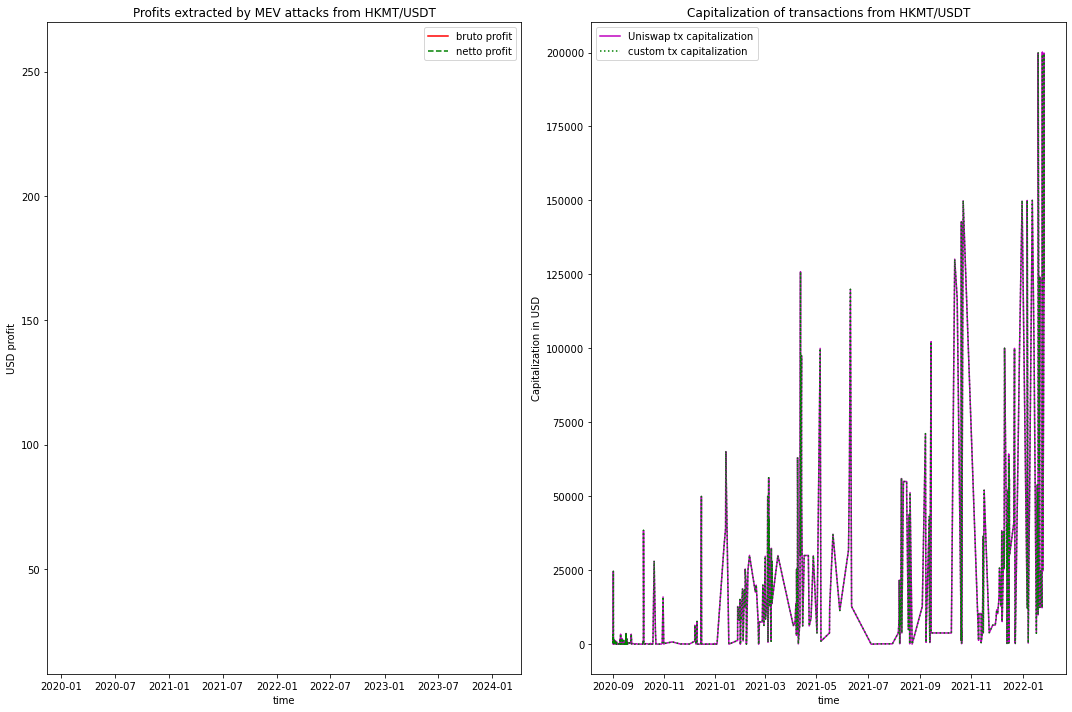

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.plot(grouped_hkmt_usdt_profits_df['timestamp'], grouped_hkmt_usdt_profits_df['bruto_total_profit'], label='bruto profit', color='r')
ax1.plot(grouped_hkmt_usdt_profits_df['timestamp'], grouped_hkmt_usdt_profits_df['netto_profit'], label='netto profit', color='g', linestyle='--')
ax1.set_xlabel('time')
ax1.set_ylabel('USD profit')
ax1.set_title('Profits extracted by MEV attacks from HKMT/USDT')
ax1.legend()

ax2.plot(hkmt_usdt_swaps_df['timestamp'], hkmt_usdt_swaps_df['amount_usd'], label="Uniswap tx capitalization", color='m')
ax2.plot(hkmt_usdt_swaps_df['timestamp'], hkmt_usdt_swaps_df['total_cap'] / 2, label="custom tx capitalization", color='g',
         linestyle=':')
ax2.set_xlabel('time')
ax2.set_ylabel('Capitalization in USD')
ax2.set_title('Capitalization of transactions from HKMT/USDT')
ax2.legend()

plt.tight_layout()
plt.show()

## IXS/WETH

In [114]:
ixs_weth_filtered_swaps_df, ixs_weth_mevs_df = ixs_weth_sim.extract_filtered_and_mevs_dfs()
ixs_weth_mevs_df

initial len = 2474, filtered len = 2334
txds = 140
out values = 70


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used
1,IXS,WETH,10781.086133,1.010521,3412.553806,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x05314a2d9bb717a8b4d3b4349d698e9e8c5fd08a6421...,1401228981326,128263
2,WETH,IXS,0.886100,10781.086133,3050.396683,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1383c605487ded022ad75231fcb5383841b0c4ef2241...,76362622163,500010
7,WETH,IXS,0.773200,7766.986865,2655.852184,2021-09-08 13:00:36,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x25d8279ad0999da08ee30d50204ad5b606d1d956a699...,91317423228,500000
8,IXS,WETH,7766.986865,0.817983,2769.999554,2021-09-08 13:00:36,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x526e0c4e2ee3418dd8e6686d40917b0a67792fe1bf77...,450303637056,128253
18,IXS,WETH,18797.405327,2.438961,8138.300442,2021-09-08 13:02:58,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x99a8bf002c0989007f93a87150544209f017049f0883...,125484591456,2000000
...,...,...,...,...,...,...,...,...,...,...,...
2367,WETH,IXS,3.258591,64615.874809,10215.913104,2022-01-09 05:32:54,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,96534076405,200000
2370,WETH,IXS,0.204570,4417.639844,641.339915,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,109600853456,550988
2372,IXS,WETH,4417.639844,0.223684,701.263874,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,117286586847,128261
2458,WETH,IXS,9.850424,153715.045388,27919.796295,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0da2303947534ae2992d7306e4856859020137e50186...,135879365521,108545


In [115]:
ixs_weth_mevs_df = ixs_weth_sim.calculate_attack_profit(ixs_weth_mevs_df)
ixs_weth_mevs_df = ixs_weth_sim.calculate_attack_profit_by_token(ixs_weth_mevs_df)

In [116]:
ixs_price_df = ixs_weth_sim.get_daily_token_price(first_to_second=False, token_name='IXS')
ixs_price_df['date'] = ixs_price_df['date'].dt.strftime("%Y-%m-%d")
ixs_price_df

,date,IXS_price
0,2021-09-08,0.000147
1,2021-09-09,0.000142
2,2021-09-10,0.000141
3,2021-09-11,0.000204
4,2021-09-12,0.000219
...,...,...
133,2022-01-21,0.000052
134,2022-01-22,0.000048
135,2022-01-23,0.000049
136,2022-01-24,0.000046


In [117]:
ixs_weth_mevs_df['date'] = ixs_weth_mevs_df['timestamp'].dt.strftime("%Y-%m-%d")
ixs_weth_mevs_df = pd.merge(ixs_weth_mevs_df, ixs_price_df, on='date', how='left')
ixs_weth_mevs_df = pd.merge(ixs_weth_mevs_df, weth_price_df, on='date', how='left')
ixs_weth_mevs_df = pd.merge(ixs_weth_mevs_df, classic_pools_mevs_df, on='txd', how='left')

### Brutto/netto profit calculation

In [118]:
ixs_weth_mevs_df['bruto_ixs_to_weth_profit'] = ixs_weth_mevs_df['IXS_profit'] * ixs_weth_mevs_df['IXS_price']
ixs_weth_mevs_df['bruto_total_profit'] = ((ixs_weth_mevs_df['bruto_ixs_to_weth_profit'] * ixs_weth_mevs_df['WETH_price']) +
                                          (ixs_weth_mevs_df['WETH_profit'] * ixs_weth_mevs_df['WETH_price']))
ixs_weth_mevs_df.loc[ixs_weth_mevs_df['tx_fee'] >= 1, 'tx_fee'] = ixs_weth_mevs_df['tx_fee'].median()
ixs_weth_mevs_df.loc[ixs_weth_mevs_df['tx_fee'] == 0, 'tx_fee'] = ixs_weth_mevs_df['tx_fee'].median()
ixs_weth_mevs_df['gas_costs_usd'] = (ixs_weth_mevs_df['tx_fee'] * ixs_weth_mevs_df['WETH_price'] *
                                      ixs_weth_mevs_df['gas_usage_by_tx'])
ixs_weth_mevs_df['netto_profit'] = ixs_weth_mevs_df['bruto_total_profit'] - ixs_weth_mevs_df['gas_costs_usd']
ixs_weth_mevs_df.dropna(inplace=True)
ixs_weth_mevs_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_ixs_to_weth_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,IXS,WETH,10781.086133,1.010521,3412.553806,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x05314a2d9bb717a8b4d3b4349d698e9e8c5fd08a6421...,1401228981326,...,3492.304847,13185242,2,78263,3499.69,1.401229e-06,0.0,434.515342,382.981459,51.533883
1,WETH,IXS,0.886100,10781.086133,3050.396683,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1383c605487ded022ad75231fcb5383841b0c4ef2241...,76362622163,...,3492.304847,13185242,0,139473,3499.69,7.636262e-08,0.0,434.515342,37.194877,397.320465
2,WETH,IXS,0.773200,7766.986865,2655.852184,2021-09-08 13:00:36,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x25d8279ad0999da08ee30d50204ad5b606d1d956a699...,91317423228,...,3492.304847,13185246,4,88351,3499.69,9.131742e-08,0.0,156.397460,28.175865,128.221594
3,IXS,WETH,7766.986865,0.817983,2769.999554,2021-09-08 13:00:36,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x526e0c4e2ee3418dd8e6686d40917b0a67792fe1bf77...,450303637056,...,3492.304847,13185246,6,78253,3499.69,4.503036e-07,0.0,156.397460,123.060478,33.336982
4,IXS,WETH,18797.405327,2.438961,8138.300442,2021-09-08 13:02:58,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x99a8bf002c0989007f93a87150544209f017049f0883...,125484591456,...,3492.304847,13185257,4,89823,3499.69,1.254846e-07,0.0,133.319598,39.363173,93.956424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,WETH,IXS,3.258591,64615.874809,10215.913104,2022-01-09 05:32:54,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,96534076405,...,3138.028260,13969479,1,87023,3150.83,9.653408e-08,0.0,390.953635,26.361587,364.592048
140,WETH,IXS,0.204570,4417.639844,641.339915,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,109600853456,...,3138.028260,13969481,2,88383,3150.83,1.096009e-07,0.0,59.980496,30.397616,29.582880
141,IXS,WETH,4417.639844,0.223684,701.263874,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,117286586847,...,3138.028260,13969481,4,78261,3150.83,1.172866e-07,0.0,59.980496,28.803853,31.176643
142,WETH,IXS,9.850424,153715.045388,27919.796295,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0da2303947534ae2992d7306e4856859020137e50186...,135879365521,...,2569.459817,14049774,0,88481,2569.59,1.358794e-07,0.0,1211.381392,30.891953,1180.489439


In [119]:
print(len(ixs_weth_mevs_df))
ixs_weth_mevs_df.drop_duplicates(subset=["timestamp", "amount_in", "txd", "block", "block_position"], inplace=True)
print(len(ixs_weth_mevs_df))
ixs_weth_mevs_df

144
140


,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_ixs_to_weth_profit,bruto_total_profit,gas_costs_usd,netto_profit
0,IXS,WETH,10781.086133,1.010521,3412.553806,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x05314a2d9bb717a8b4d3b4349d698e9e8c5fd08a6421...,1401228981326,...,3492.304847,13185242,2,78263,3499.69,1.401229e-06,0.0,434.515342,382.981459,51.533883
1,WETH,IXS,0.886100,10781.086133,3050.396683,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1383c605487ded022ad75231fcb5383841b0c4ef2241...,76362622163,...,3492.304847,13185242,0,139473,3499.69,7.636262e-08,0.0,434.515342,37.194877,397.320465
2,WETH,IXS,0.773200,7766.986865,2655.852184,2021-09-08 13:00:36,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x25d8279ad0999da08ee30d50204ad5b606d1d956a699...,91317423228,...,3492.304847,13185246,4,88351,3499.69,9.131742e-08,0.0,156.397460,28.175865,128.221594
3,IXS,WETH,7766.986865,0.817983,2769.999554,2021-09-08 13:00:36,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x526e0c4e2ee3418dd8e6686d40917b0a67792fe1bf77...,450303637056,...,3492.304847,13185246,6,78253,3499.69,4.503036e-07,0.0,156.397460,123.060478,33.336982
4,IXS,WETH,18797.405327,2.438961,8138.300442,2021-09-08 13:02:58,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x00000000003b3cc22af3ae1eac0440bcee416b40,0x99a8bf002c0989007f93a87150544209f017049f0883...,125484591456,...,3492.304847,13185257,4,89823,3499.69,1.254846e-07,0.0,133.319598,39.363173,93.956424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,WETH,IXS,3.258591,64615.874809,10215.913104,2022-01-09 05:32:54,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,96534076405,...,3138.028260,13969479,1,87023,3150.83,9.653408e-08,0.0,390.953635,26.361587,364.592048
140,WETH,IXS,0.204570,4417.639844,641.339915,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,109600853456,...,3138.028260,13969481,2,88383,3150.83,1.096009e-07,0.0,59.980496,30.397616,29.582880
141,IXS,WETH,4417.639844,0.223684,701.263874,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,117286586847,...,3138.028260,13969481,4,78261,3150.83,1.172866e-07,0.0,59.980496,28.803853,31.176643
142,WETH,IXS,9.850424,153715.045388,27919.796295,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0da2303947534ae2992d7306e4856859020137e50186...,135879365521,...,2569.459817,14049774,0,88481,2569.59,1.358794e-07,0.0,1211.381392,30.891953,1180.489439


### Bigger sandwiches and profits

In [120]:
ixs_weth_count_df = ixs_weth_mevs_df.value_counts(subset=['timestamp'])
ixs_weth_count_df[ixs_weth_count_df.values > 2]

timestamp          
2021-09-08 13:07:38    4
dtype: int64

In [121]:
ixs_weth_mevs_df[ixs_weth_mevs_df['timestamp'] == datetime.fromisoformat("2021-09-08 13:07:38")]

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_price,block,block_position,gas_usage_by_tx,ether_price,tx_fee,bruto_ixs_to_weth_profit,bruto_total_profit,gas_costs_usd,netto_profit
8,IXS,WETH,29721.393528,4.032803,13269.738315,2021-09-08 13:07:38,0x000000000027d2efc283613d0c3e24a8b430c4d8,0x000000000027d2efc283613d0c3e24a8b430c4d8,0x1eb2d5aaa5250e830b441bbcfe5631ca593d9b417de6...,114632937114,...,3492.304847,13185272,5,102478,3499.69,1.146329e-07,0.0,1033.754786,41.025342,992.729444
10,WETH,IXS,0.883100,6862.021792,3033.084955,2021-09-08 13:07:38,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x41e58c45b35e3f532834dd9590d12d1e471351cc85be...,114632937114,...,3492.304847,13185272,9,83740,3499.69,1.146329e-07,0.0,93.428159,33.523899,59.904260
12,IXS,WETH,6862.021792,0.909853,3080.895385,2021-09-08 13:07:38,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x6de68751d08d59e5601fc35c663bdf9154ee6f0a11e7...,161146891418,...,3492.304847,13185272,11,84794,3499.69,1.611469e-07,0.0,93.428159,47.719864,45.708295
14,WETH,IXS,3.736794,29721.393528,13206.873582,2021-09-08 13:07:38,0x000000000027d2efc283613d0c3e24a8b430c4d8,0x000000000027d2efc283613d0c3e24a8b430c4d8,0x951e76661e81e07e6bf7f99a3f8266d3c3f950713fb4...,114632937114,...,3492.304847,13185272,2,111300,3499.69,1.146329e-07,0.0,1033.754786,44.557081,989.197705


In [122]:
grouped_ixs_weth_profits_df = ixs_weth_mevs_df.groupby(by=['timestamp']).sum()
grouped_ixs_weth_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_ixs_weth_profits_df['block'] = grouped_ixs_weth_profits_df['block'] / 2
grouped_ixs_weth_profits_df['bruto_total_profit'] = grouped_ixs_weth_profits_df['bruto_total_profit']/2
grouped_ixs_weth_profits_df['netto_profit'] = (grouped_ixs_weth_profits_df['bruto_total_profit'] -
                                               grouped_ixs_weth_profits_df['gas_costs_usd'])
grouped_ixs_weth_profits_df.reset_index(inplace=True)

print(fr"max brutto profit {grouped_ixs_weth_profits_df['bruto_total_profit'].max()}")
print(fr"min brutto profit {grouped_ixs_weth_profits_df['bruto_total_profit'].min()}")
print(fr"max netto profit {grouped_ixs_weth_profits_df['netto_profit'].max()}")
print(fr"min netto profit {grouped_ixs_weth_profits_df['netto_profit'].min()}")
print(fr"zero bruto profit transactions = {len(ixs_weth_mevs_df[ixs_weth_mevs_df['bruto_total_profit'] == 0])}")
print(fr"transactions with losses = {len(ixs_weth_mevs_df[ixs_weth_mevs_df['netto_profit'] < 0])}")

max brutto profit 1717.660110974782
min brutto profit 24.24542348122092
max netto profit 1579.2484245869837
min netto profit 0.003706756378278442
zero bruto profit transactions = 0
transactions with losses = 0


In [123]:
print(fr"sum of paid gas = {sum(ixs_weth_mevs_df['gas_costs_usd'])}")
print(fr"sum of brutto profits = {sum(ixs_weth_mevs_df['bruto_total_profit'] / 2)}")
print(fr"sum of netto profits = {sum(ixs_weth_mevs_df['bruto_total_profit'] / 2) - sum(ixs_weth_mevs_df['gas_costs_usd'])}")

sum of paid gas = 12776.206354169499
sum of brutto profits = 21001.273490314776
sum of netto profits = 8225.067136145277


### Brutto profit to Uniswap capitalization coefficient

In [124]:
print("brutto attacks profits (" + str(sum(ixs_weth_mevs_df['bruto_total_profit'] / 2)) +
      ") to IXS/WETH Uniswap capitalization (" + str(ixs_weth_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(ixs_weth_mevs_df['bruto_total_profit'] / 2) / ixs_weth_swaps_df['amount_usd'].sum()))

brutto attacks profits (21001.273490314776) to IXS/WETH Uniswap capitalization (9511105.447262365) coef is equal to 0.0022080791351503405


### Brutto profit to custom capitalization coefficient

It is important to perform manual check of the first token value and second token value, considering that it is not possible to set correct token name from the start and requiring manual check of values

In [125]:
ixs_weth_swaps_df = ixs_weth_sim.calculate_attack_profit_by_token(ixs_weth_swaps_df)
ixs_weth_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,gas_used,first_token_value,second_token_value,IXS_profit,WETH_profit
0,WETH,IXS,12.000000,211315.866941,49367.994152,2021-09-08 12:59:29,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x03a92ec2e6ceee63731cd49d99050d24a40ba25a,0x2df317ab076e29ca317edf45a6e484a3acef1674def4...,125000000000,500000,211315.866941,12.000000,0.0,0.000000
1,IXS,WETH,10781.086133,1.010521,3412.553806,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x05314a2d9bb717a8b4d3b4349d698e9e8c5fd08a6421...,1401228981326,128263,10781.086133,1.010521,0.0,0.124421
2,WETH,IXS,0.886100,10781.086133,3050.396683,2021-09-08 12:59:42,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x1383c605487ded022ad75231fcb5383841b0c4ef2241...,76362622163,500010,10781.086133,0.886100,0.0,0.124421
3,WETH,IXS,3.000000,33333.139648,10583.791945,2021-09-08 12:59:42,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x3d55017098970268414f4b9252fdbe18cd09dcc3,0xad4556f77687567af93ea9587d89be78bff951133808...,555000000000,400000,33333.139648,3.000000,0.0,0.000000
4,WETH,IXS,0.146153,1580.639685,498.586381,2021-09-08 12:59:58,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdf33624ed4623a3dea8be15ce5a4623d26d0a246,0x4dc080fadc4b5c1abe6613250689a672b54ab06db779...,74913753619,273355,1580.639685,0.146153,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,IXS,WETH,2500.000000,0.116556,294.604514,2022-01-23 11:17:49,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x48a04cea7e4c9cb8c83c8002d56de23ed2c8f21618a5...,100976572367,173323,2500.000000,0.116556,0.0,0.000000
2470,IXS,WETH,2176.037004,0.100911,252.192779,2022-01-23 12:03:48,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa09f83837bc369ae66e37850938e81e1dcc95918f281...,73042587495,220866,2176.037004,0.100911,0.0,0.000000
2471,WETH,IXS,1.100000,23016.019768,2629.665370,2022-01-23 19:50:20,0xbdb292dac4939557b011c1cfecba37f077774130,0x5f0bee213e5dc3f7b7ca2a9d0b854468974802c4,0x138e40ef226cc74cceeee5f5737f32bc0e17c23ca592...,146914416968,167438,23016.019768,1.100000,0.0,0.000000
2472,IXS,WETH,24068.759310,1.142153,2780.392867,2022-01-24 22:29:40,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbf5ae133b9a0fc1a07952a7df2afa21f7f69ef58,0x6f80f22762d79f1558eccb08bba7867bf6deda9de7b1...,134003458357,250000,24068.759310,1.142153,0.0,0.000000


In [126]:
ixs_price_df = ixs_weth_sim.get_daily_token_price(first_to_second=False, token_name='IXS')
ixs_price_df['date'] = ixs_price_df['date'].dt.strftime("%Y-%m-%d")
ixs_price_df

,date,IXS_price
0,2021-09-08,0.000147
1,2021-09-09,0.000142
2,2021-09-10,0.000141
3,2021-09-11,0.000204
4,2021-09-12,0.000219
...,...,...
133,2022-01-21,0.000052
134,2022-01-22,0.000048
135,2022-01-23,0.000049
136,2022-01-24,0.000046


In [127]:
ixs_weth_swaps_df['date'] = ixs_weth_swaps_df['timestamp'].dt.strftime("%Y-%m-%d")
ixs_weth_swaps_df = pd.merge(ixs_weth_swaps_df, ixs_price_df, on='date', how='left')
ixs_weth_swaps_df = pd.merge(ixs_weth_swaps_df, weth_price_df, on='date', how='left')
ixs_weth_swaps_df['cap_ixs_to_usdc'] = (ixs_weth_swaps_df['first_token_value'] * ixs_weth_swaps_df['IXS_price'] *
                                         ixs_weth_swaps_df['WETH_price'])
ixs_weth_swaps_df['cap_weth_to_usdc'] = ixs_weth_swaps_df['second_token_value'] * ixs_weth_mevs_df['WETH_price']
ixs_weth_swaps_df['total_cap'] = ixs_weth_swaps_df['cap_ixs_to_usdc'] + ixs_weth_swaps_df['cap_weth_to_usdc']

In [128]:
print("brutto attacks profits (" + str(sum(ixs_weth_mevs_df['bruto_total_profit'] / 2)) +
      ") to IXS/WETH custom capitalization (" + str(ixs_weth_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(ixs_weth_mevs_df['bruto_total_profit'] / 2) / ixs_weth_swaps_df['total_cap'].sum() / 2))

brutto attacks profits (21001.273490314776) to IXS/WETH custom capitalization (789574.3484887572) coef is equal to 0.0066495553998528285


### Netto profit to Uniswap capitalization coefficient

In [129]:
print("netto attacks profits (" + str(sum(ixs_weth_mevs_df['netto_profit'] / 2)) +
      ") to IXS/WETH Uniswap capitalization (" + str(ixs_weth_swaps_df['amount_usd'].sum()) +
      ") coef is equal to " + str(sum(ixs_weth_mevs_df['netto_profit'] / 2) / ixs_weth_swaps_df['amount_usd'].sum()))

netto attacks profits (14613.170313230035) to IXS/WETH Uniswap capitalization (9511105.447262365) coef is equal to 0.0015364323731092925


### Netto profit to custom capitalization coefficient

In [130]:
print("netto attacks profits (" + str(sum(ixs_weth_mevs_df['netto_profit'] / 2)) +
      ") to IXS/WETH custom capitalization (" + str(ixs_weth_swaps_df['total_cap'].sum() / 2) +
      ") coef is equal to " + str(sum(ixs_weth_mevs_df['netto_profit'] / 2) / ixs_weth_swaps_df['total_cap'].sum() / 2))

netto attacks profits (14613.170313230035) to IXS/WETH custom capitalization (789574.3484887572) coef is equal to 0.004626913963580377


### MEV transactions frequency to standard transactions

MEVs frequency is extremely small and can be seen that there is almost no MEV activity registered in such a big pool

In [131]:
print("IXS/WETH pool contains " + str(len(ixs_weth_mevs_df) / 2) + " MEV attacks (or " +
      str(len(ixs_weth_mevs_df)) + " MEV transactions) out of " + str(len(ixs_weth_swaps_df)) +
      " total transactions." +
      "\nCoefficient of MEV attacks = " + str((len(ixs_weth_mevs_df) / 2) / len(ixs_weth_swaps_df)) +
      "; coefficient of MEV transactions = " + str(len(ixs_weth_mevs_df) / len(ixs_weth_swaps_df)) +
      "\nCoef of MEV attacks cap = " + str(ixs_weth_mevs_df['amount_usd'].sum() / ixs_weth_swaps_df['amount_usd'].sum()))

IXS/WETH pool contains 70.0 MEV attacks (or 140 MEV transactions) out of 2474 total transactions.
Coefficient of MEV attacks = 0.028294260307194827; coefficient of MEV transactions = 0.056588520614389654
Coef of MEV attacks cap = 0.11587107261497076


### Distributions of profits and capitalizations

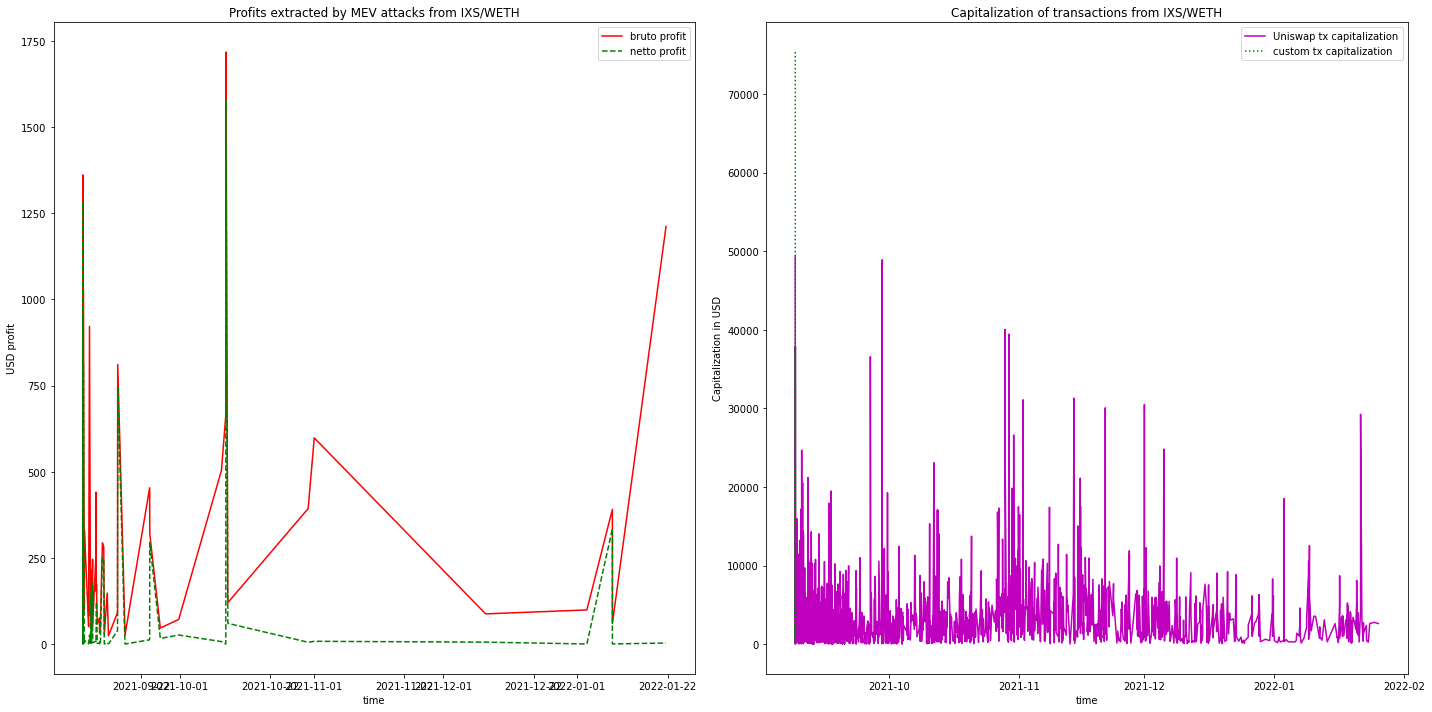

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.plot(grouped_ixs_weth_profits_df['timestamp'], grouped_ixs_weth_profits_df['bruto_total_profit'], label='bruto profit', color='r')
ax1.plot(grouped_ixs_weth_profits_df['timestamp'], grouped_ixs_weth_profits_df['netto_profit'], label='netto profit', color='g', linestyle='--')
ax1.set_xlabel('time')
ax1.set_ylabel('USD profit')
ax1.set_title('Profits extracted by MEV attacks from IXS/WETH')
ax1.legend()

ax2.plot(ixs_weth_swaps_df['timestamp'], ixs_weth_swaps_df['amount_usd'], label="Uniswap tx capitalization", color='m')
ax2.plot(ixs_weth_swaps_df['timestamp'], ixs_weth_swaps_df['total_cap'] / 2, label="custom tx capitalization", color='g',
         linestyle=':')
ax2.set_xlabel('time')
ax2.set_ylabel('Capitalization in USD')
ax2.set_title('Capitalization of transactions from IXS/WETH')
ax2.legend()

plt.tight_layout()
plt.show()

# Collecting all MEVs into one big history and saving it locally

In [133]:
classic_pools_swaps_list = [wbtc_usdc_swaps_df, weth_usdc_swaps_df, wbtc_dai_swaps_df,
                          fei_weth_swaps_df, hkmt_usdt_swaps_df, ixs_weth_swaps_df]
classic_pools_swaps_df = pd.concat(classic_pools_swaps_list)
classic_pools_swaps_df

,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,txd,gas_price,...,WETH_profit,cap_weth_to_usdc,DAI_profit,FEI_profit,HKMT_profit,USDT_profit,HKMT_price,IXS_profit,IXS_price,cap_ixs_to_usdc
0,USDC,WBTC,1.534170e-01,0.000016,0.152773,2020-05-19 23:44:23,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x3da4491fed9f6d6b1391b2a02991c8d035d7716f,0xba9a47ed6b7d293da7e7643f434055ff76bdf609274f...,16500000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WBTC,USDC,2.501000e-04,2.367365,2.371854,2020-05-21 14:39:56,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0xffff2870fd0aa2f909766844c95f53b83625854c925e...,65666700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WBTC,USDC,1.047330e-03,9.603013,9.593976,2020-05-22 20:47:02,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x96569f124f6a3b62093c7115f14f8005705ba48a,0x68e9800197efaafee864d33cf6167d12e4aa29a527c9...,25300000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USDC,WBTC,8.923190e-01,0.000098,0.891249,2020-05-23 14:00:42,0x0d4743269fec611b422d0a209a460cd8cc0cc8b9,0x0d4743269fec611b422d0a209a460cd8cc0cc8b9,0x33fbec2e6e1a3a04a1f5109f3a8809f32c7ad7e75c7d...,35640000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WBTC,USDC,1.100000e-07,0.001000,0.000995,2020-05-24 17:37:32,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x211b6a1137bf539b2750e02b9e525cf5757a35ae,0x273375cad4d5cf584b70af639f3cf07a53ba00a07216...,31000010000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,IXS,WETH,2.500000e+03,0.116556,294.604514,2022-01-23 11:17:49,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x48a04cea7e4c9cb8c83c8002d56de23ed2c8f21618a5...,100976572367,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000049,310.081853
2470,IXS,WETH,2.176037e+03,0.100911,252.192779,2022-01-23 12:03:48,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa09f83837bc369ae66e37850938e81e1dcc95918f281...,73042587495,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000049,269.899835
2471,WETH,IXS,1.100000e+00,23016.019768,2629.665370,2022-01-23 19:50:20,0xbdb292dac4939557b011c1cfecba37f077774130,0x5f0bee213e5dc3f7b7ca2a9d0b854468974802c4,0x138e40ef226cc74cceeee5f5737f32bc0e17c23ca592...,146914416968,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000049,2854.740024
2472,IXS,WETH,2.406876e+04,1.142153,2780.392867,2022-01-24 22:29:40,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xbf5ae133b9a0fc1a07952a7df2afa21f7f69ef58,0x6f80f22762d79f1558eccb08bba7867bf6deda9de7b1...,134003458357,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000046,2718.377441


In [134]:
chosen_columns = ['timestamp', 'sender', 'amount_usd', 'to', 'txd', 'block', 'block_position', 'bruto_total_profit',
                  'tx_fee', 'gas_usage_by_tx', 'gas_costs_usd','netto_profit']

wbtc_usdc_profits_df = wbtc_usdc_mevs_df[chosen_columns]
weth_usdc_profits_df = weth_usdc_mevs_df[chosen_columns]
wbtc_dai_profits_df = wbtc_dai_mevs_df[chosen_columns]
fei_weth_profits_df = fei_weth_mevs_df[chosen_columns]
hkmt_usdt_profits_df = hkmt_usdt_mevs_df[chosen_columns]
ixs_weth_profits_df = ixs_weth_mevs_df[chosen_columns]

wbtc_usdc_profits_df['pool_name'] = 'WBTC/USDC'
weth_usdc_profits_df['pool_name'] = 'WETH/USDC'
wbtc_dai_profits_df['pool_name'] = 'WBTC/DAI'
fei_weth_profits_df['pool_name'] = 'FEI/WETH'
hkmt_usdt_profits_df['pool_name'] = 'HKMT/USDT'
ixs_weth_profits_df['pool_name'] = 'IXS/WETH'

classic_profits_list = [wbtc_usdc_profits_df, weth_usdc_profits_df, wbtc_dai_profits_df,
                            fei_weth_profits_df, hkmt_usdt_profits_df, ixs_weth_profits_df]
classic_profits_df = pd.concat(classic_profits_list)
classic_profits_df

<ipython-input-134-12eb57c82e67>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbtc_usdc_profits_df['pool_name'] = 'WBTC/USDC'
<ipython-input-134-12eb57c82e67>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weth_usdc_profits_df['pool_name'] = 'WETH/USDC'
<ipython-input-134-12eb57c82e67>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,timestamp,sender,amount_usd,to,txd,block,block_position,bruto_total_profit,tx_fee,gas_usage_by_tx,gas_costs_usd,netto_profit,pool_name
0,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,3684.217300,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,11279366,54,24.758508,1.220000e-07,107326,6.295455,18.463053,WBTC/USDC
1,2020-11-18 02:55:12,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,3692.331147,0x341c8dc3a41be16ce427c15a625983bdef2d2f27,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,11279366,62,24.758508,1.155000e-07,101057,5.611911,19.146597,WBTC/USDC
2,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,30517.868246,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,11792953,75,206.102171,2.431000e-07,66799,27.898182,178.203989,WBTC/USDC
3,2021-02-05 00:08:00,0x60f09b45dd707d0dda43f099bd87c0f49d483979,30311.720370,0x60f09b45dd707d0dda43f099bd87c0f49d483979,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,11792953,3,206.102171,3.014638e-07,103505,53.606510,152.495661,WBTC/USDC
4,2021-02-06 16:53:21,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,11693.344352,0x102249e2954f88acc4e4b24395be71eafdb4c2a9,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,11803970,67,109.058743,1.404000e-07,139130,32.864347,76.194396,WBTC/USDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2022-01-09 05:32:54,0x499dd900f800fd0a2ed300006000a57f00fa009b,10215.913104,0x499dd900f800fd0a2ed300006000a57f00fa009b,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,13969479,1,390.953635,9.653408e-08,87023,26.361587,364.592048,IXS/WETH
140,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,641.339915,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,13969481,2,59.980496,1.096009e-07,88383,30.397616,29.582880,IXS/WETH
141,2022-01-09 05:33:21,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,701.263874,0x1d6e8bac6ea3730825bde4b005ed7b2b39a2932d,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,13969481,4,59.980496,1.172866e-07,78261,28.803853,31.176643,IXS/WETH
142,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,27919.796295,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,1211.381392,1.358794e-07,88481,30.891953,1180.489439,IXS/WETH


In [135]:
classic_profits_df.sort_values(by=['timestamp'], inplace=True)
classic_profits_df = classic_profits_df.reset_index()
classic_profits_df.drop(columns=['index'])

,timestamp,sender,amount_usd,to,txd,block,block_position,bruto_total_profit,tx_fee,gas_usage_by_tx,gas_costs_usd,netto_profit,pool_name
0,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,327.607980,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x25cbd0282ccbf79b3ca04182e650f8e54bbf328b2b82...,10227255,265,2.479838,3.000000e-08,110051,0.811889,1.667950,WETH/USDC
1,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,326.322863,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x23a0a0c4fec8ce3bbede81ed4a86c8b1977a6faf70a6...,10227255,54,2.479838,3.000000e-08,134242,0.990355,1.489483,WETH/USDC
2,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,725.226810,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0xe557a7c9ac7358929c5c01025059bc585c79b1bc4ebe...,10231112,184,1.841951,4.000000e-08,134242,1.304660,0.537291,WETH/USDC
3,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,727.494505,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x0472b0bda03549ad0ced339ad1872b76fd9a2ee1f6df...,10231112,207,1.841951,4.000000e-08,110039,1.069438,0.772513,WETH/USDC
4,2020-06-11 17:08:03,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,687.037932,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,0x5e4e8e817bc0b69936ac65c07e45547438788f4a1fac...,10245640,118,3.693123,5.720000e-08,134242,1.772183,1.920941,WETH/USDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,27919.796295,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,1211.381392,1.358794e-07,88481,30.891953,1180.489439,IXS/WETH
706,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,37647.553852,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0xa140f3f688511238df8a9e564a97e480e0cec7868bfe...,14054109,1,345.926450,3.064305e-07,104051,76.682459,269.243991,WBTC/USDC
707,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,37647.553852,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x94fff3ef66ab898bb1afbb9128da1ce611cc45a592ab...,14054109,3,345.926450,8.446549e-07,94113,191.181882,154.744568,WBTC/USDC
708,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,122823.392267,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x6eb7c947848fa63ebfe5ffa539a166afdb4d8043600a...,14079833,0,257.910784,8.656122e-08,102974,21.975480,235.935304,HKMT/USDT


In [136]:
grouped_classic_profits_df = classic_profits_df.value_counts(subset=['timestamp'])
grouped_classic_profits_df[grouped_classic_profits_df.values > 2]

timestamp          
2021-02-17 09:41:36    4
2021-03-13 18:13:39    4
2021-09-08 13:07:38    4
2021-04-04 02:21:56    4
dtype: int64

In [137]:
grouped_by_timestamps_classic_profits_df = classic_profits_df.groupby(by=['timestamp']).sum()
grouped_by_timestamps_classic_profits_df.drop(columns=['block_position', 'tx_fee'], inplace=True)
grouped_by_timestamps_classic_profits_df['block'] = grouped_by_timestamps_classic_profits_df['block'] / 2
grouped_by_timestamps_classic_profits_df['bruto_total_profit']= (grouped_by_timestamps_classic_profits_df['bruto_total_profit'] /
                                                                  2)
grouped_by_timestamps_classic_profits_df['netto_profit'] = grouped_by_timestamps_classic_profits_df['bruto_total_profit'] - grouped_by_timestamps_classic_profits_df['gas_costs_usd']
grouped_by_timestamps_classic_profits_df.reset_index(inplace=True)
grouped_by_timestamps_classic_profits_df

,timestamp,index,amount_usd,block,bruto_total_profit,gas_usage_by_tx,gas_costs_usd,netto_profit
0,2020-06-08 20:19:27,1,653.930843,10227255.0,2.479838,244293,1.802244,0.677595
1,2020-06-09 10:59:47,5,1452.721315,10231112.0,1.841951,244281,2.374099,-0.532147
2,2020-06-11 17:08:03,9,1377.797438,10245640.0,3.693123,244281,3.224852,0.468272
3,2020-06-12 09:04:44,13,1420.315793,10249924.0,1.859145,244281,1.917475,-0.058329
4,2020-06-12 12:59:39,17,1424.601535,10251011.0,2.339545,244281,2.382317,-0.042772
...,...,...,...,...,...,...,...,...
346,2022-01-21 03:12:38,57,141680.294176,14046451.0,614.289021,170396,413.411924,200.877097
347,2022-01-21 03:35:28,61,67656.648863,14046540.0,473.808041,182385,139.104935,334.703105
348,2022-01-21 15:38:15,285,57175.869209,14049774.0,1211.381392,167181,1208.020790,3.360602
349,2022-01-22 07:36:40,385,75295.107704,14054109.0,345.926450,198164,267.864341,78.062109


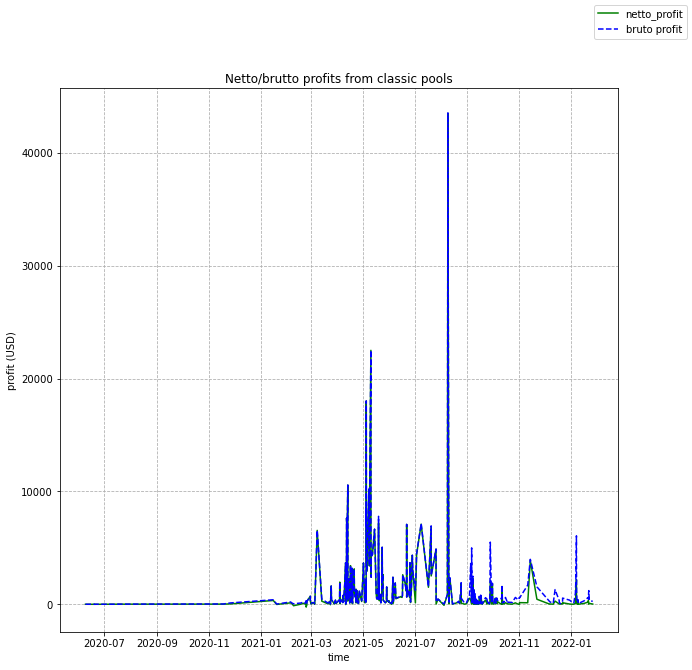

In [138]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(grouped_by_timestamps_classic_profits_df['timestamp'], grouped_by_timestamps_classic_profits_df['netto_profit'],
        label='netto_profit', color='g')
ax.plot(grouped_by_timestamps_classic_profits_df['timestamp'], grouped_by_timestamps_classic_profits_df['bruto_total_profit'],
        color='b', linestyle='--', label='bruto profit')
ax.set_xlabel('time')
ax.set_ylabel('profit (USD)')
ax.grid(True, linestyle='--')
ax.set_title('Netto/brutto profits from classic pools')
fig.legend()
plt.show()

In [139]:
print(fr"total classic netto = {sum(grouped_by_timestamps_classic_profits_df['netto_profit'])}")
print(fr"total classic brutto = {sum(grouped_by_timestamps_classic_profits_df['bruto_total_profit'])}")
print(fr"total gas spendings in USD = {sum(grouped_by_timestamps_classic_profits_df['gas_costs_usd'])}")
print("capitalization of MEV attacks conform Uniswap is " + str(classic_profits_df['amount_usd'].sum()) +
      " and out of total classic pools capitalization is " + str(classic_pools_swaps_df['amount_usd'].sum()) +
      ", meaning that capitalization coefficient is " + str(classic_profits_df['netto_profit'].sum() / classic_pools_swaps_df['amount_usd'].sum()))
print("count of MEV transactions on classic pools is " + str(len(classic_profits_df)) +
      " and total classic pools transaction count equal to " + str(len(classic_pools_swaps_df)) +
      ", lead to frequency of MEV attacks to all transactions " + str(len(classic_profits_df) / len(classic_pools_swaps_df)))

total classic netto = 423920.2953375705
total classic brutto = 480791.1465898065
total gas spendings in USD = 56870.851252235894
capitalization of MEV attacks conform Uniswap is 129619086.4358882 and out of total classic pools capitalization is 40936487555.755585, meaning that capitalization coefficient is 2.2100368056618384e-05
count of MEV transactions on classic pools is 710 and total classic pools transaction count equal to 3044620, lead to frequency of MEV attacks to all transactions 0.00023319823163481815


In [140]:
classic_profits_df.to_csv('classic_exact_mevs_profits_df.csv')
grouped_by_timestamps_classic_profits_df.to_csv('timestamp_grouped_classic_exact_mevs_profits_df.csv')